In [33]:
import cv2
import clip
import json
import torch
import smplx
import random
import trimesh
import numpy as np
import open3d as o3d
from copy import copy
from PIL import Image
from pathlib import Path
from typing import Tuple
import matplotlib.pyplot as plt
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (look_at_view_transform, 
                                FoVPerspectiveCameras,
                                SoftPhongShader, 
                                PointLights, 
                                Materials, 
                                BlendParams,
                                TexturesVertex,
                                RasterizationSettings,
                                MeshRenderer,
                                MeshRasterizer,
                                TexturesUV
                                )

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Prepare Pytorch3D Renderer

In [4]:
class Pytorch3dRenderer:
    def __init__(self, 
                 device='cuda', 
                 dist: float = 4.0, 
                 elev: float= 30.0, 
                 azim: float = 0.0,
                 img_size: Tuple[int, int] = (512, 512),
                 tex_path: str = None
                ):
                
        self.device = device
        self.tex_map = cv2.imread(tex_path) if tex_path is not None else None
        self.height, self.width = img_size

        R, T = look_at_view_transform(dist=dist, azim=azim, elev=elev)
        self.cameras = FoVPerspectiveCameras(znear=0.1, T=T, R=R, fov=30).to(self.device)
        lights = self.get_default_lights(self.device)
        materials = self.get_default_materials(self.device)
        blend_params = self.get_default_blend_params()
        self.shader = SoftPhongShader(
                                        device=self.device,
                                        cameras=self.cameras,
                                        lights=lights,
                                        materials=materials,
                                        blend_params=blend_params,
                                        )
    
    @staticmethod
    def get_texture(device, vt, ft, texture):
        verts_uvs = torch.as_tensor(vt, dtype=torch.float32, device=device)
        faces_uvs = torch.as_tensor(ft, dtype=torch.long, device=device)

        texture_map = (
            torch.as_tensor(texture, device=device, dtype=torch.float32)
            / 255.0
        )

        texture = TexturesUV(
            maps=texture_map[None],
            faces_uvs=faces_uvs[None],
            verts_uvs=verts_uvs[None],
        )

    @staticmethod
    def get_default_lights(device):
        lights = PointLights(
            device=device,
            ambient_color=((0.3, 0.3, 0.3),),
            specular_color=((0.5, 0.5, 0.5),),
            location=[[0.0, 0.0, 2.0]],
        )
        return lights
    
    @staticmethod
    def get_default_materials(device):
        materials = Materials(device=device)
        return materials

    @staticmethod
    def get_default_blend_params():
        blend_params = BlendParams(
            sigma=1e-6, gamma=1e-6, background_color=(0.0, 0.0, 0.0)
        )
        return blend_params

    def render_mesh(self, verts, faces, vt=None, ft=None):
        verts = torch.as_tensor(verts, dtype=torch.float32, device=self.device)
        faces = torch.as_tensor(faces, dtype=torch.long, device=self.device)
        if self.tex_map is not None:
            assert vt is not None and ft is not None, "vt and ft must be provided if texture is provided"
            texture = self.get_texture(self.device, vt, ft, self.tex_map)
        else:
            texture = TexturesVertex(
                        verts_features=torch.ones(*verts[None].shape, device=self.device) * 0.8
                    )

        mesh = Meshes(verts=verts[None], faces=faces[None], textures=texture)
        raster_settings = RasterizationSettings(image_size=(self.height, self.width))
        renderer = MeshRenderer(
                rasterizer=MeshRasterizer(cameras=self.cameras, raster_settings=raster_settings),
                shader=self.shader,
            )
        rendered_mesh = renderer(mesh, cameras=self.cameras)
        return rendered_mesh

def find_multipliers(value: int) -> list:
    """
    Description
    -----------
    finds all of the pairs that their product is the value
    Args
    ----
    value (int) = a number that you would like to get its multipliers
    Returns
    -------
    list of the pairs that their product is the value
    """
    factors = []
    for i in range(1, int(value ** 0.5) + 1):
        if value % i == 0:
            factors.append((i, value / i))
    return factors

def get_shape(value: int) -> tuple:
    """
    Description
    -----------
    given a number it finds the best pair of integers that their product
    equals the given number.
    for example, given an input 41 it will return 5 and 8
    """
    options_list = find_multipliers(value)
    if len(options_list) == 1:
        while len(options_list) == 1:
            value -= 1
            options_list = find_multipliers(value)

    chosen_multipliers = None
    min_distance = 100
    for option in options_list:
        if abs(option[0] - option[1]) < min_distance:
            chosen_multipliers = (option[0], option[1])

    # it is better that the height will be the largest value since the image is wide
    chosen_multipliers = (int(chosen_multipliers[np.argmax(chosen_multipliers)]),
                        int(chosen_multipliers[1 - np.argmax(chosen_multipliers)]))

    return chosen_multipliers, int(value)

### Prepare SMPLX

In [5]:
class SMPLXParams:

    def __init__(self, device='cuda', betas: torch.tensor = None):
        betas: torch.Tensor = betas
        body_pose: torch.Tensor = torch.eye(3).expand(1, 21, 3, 3)
        left_hand_pose: torch.Tensor = torch.eye(3).expand(1, 15, 3, 3)
        right_hand_pose: torch.Tensor = torch.eye(3).expand(1, 15, 3, 3)
        global_orient: torch.Tensor = torch.eye(3).expand(1, 1, 3, 3)
        transl: torch.Tensor = torch.zeros(1, 3)
        jaw_pose: torch.Tensor = torch.eye(3).expand(1, 1, 3, 3)
        expression: torch.Tensor = torch.zeros(1, 100)
        self.params = {
            'betas': betas,
            'body_pose': body_pose,
            'left_hand_pose': left_hand_pose,
            'right_hand_pose': right_hand_pose,
            'global_orient': global_orient,
            'transl': transl,
            'jaw_pose': jaw_pose,
            'expression': expression,
        }

def get_smplx_model(betas: torch.tensor = None):
    smplx_model = SMPLXParams(betas=betas)
    smplx_path = "/home/nadav2/dev/repos/CGmocap/mocap/3d_models/SMPLX_NEUTRAL_2020.npz"
    smplx_layer = smplx.build_layer(
                        model_path=smplx_path,
                        num_expression_coeffs=100,
                    )
    model_data = np.load(smplx_path, allow_pickle=True)

    faces = model_data["f"].astype(np.int32)
    verts = smplx_layer(**smplx_model.params).vertices.detach().cpu().numpy()[0] + np.array([0.0, 0.4, 0.0])

    vt = np.load("/home/nadav2/dev/repos/CGmocap/mocap/utils/smplx_textures/smplx_vt.npy")
    ft = np.load("/home/nadav2/dev/repos/CGmocap/mocap/utils/smplx_textures/smplx_ft.npy")

    return verts, faces, vt, ft

### Prepare CLIP

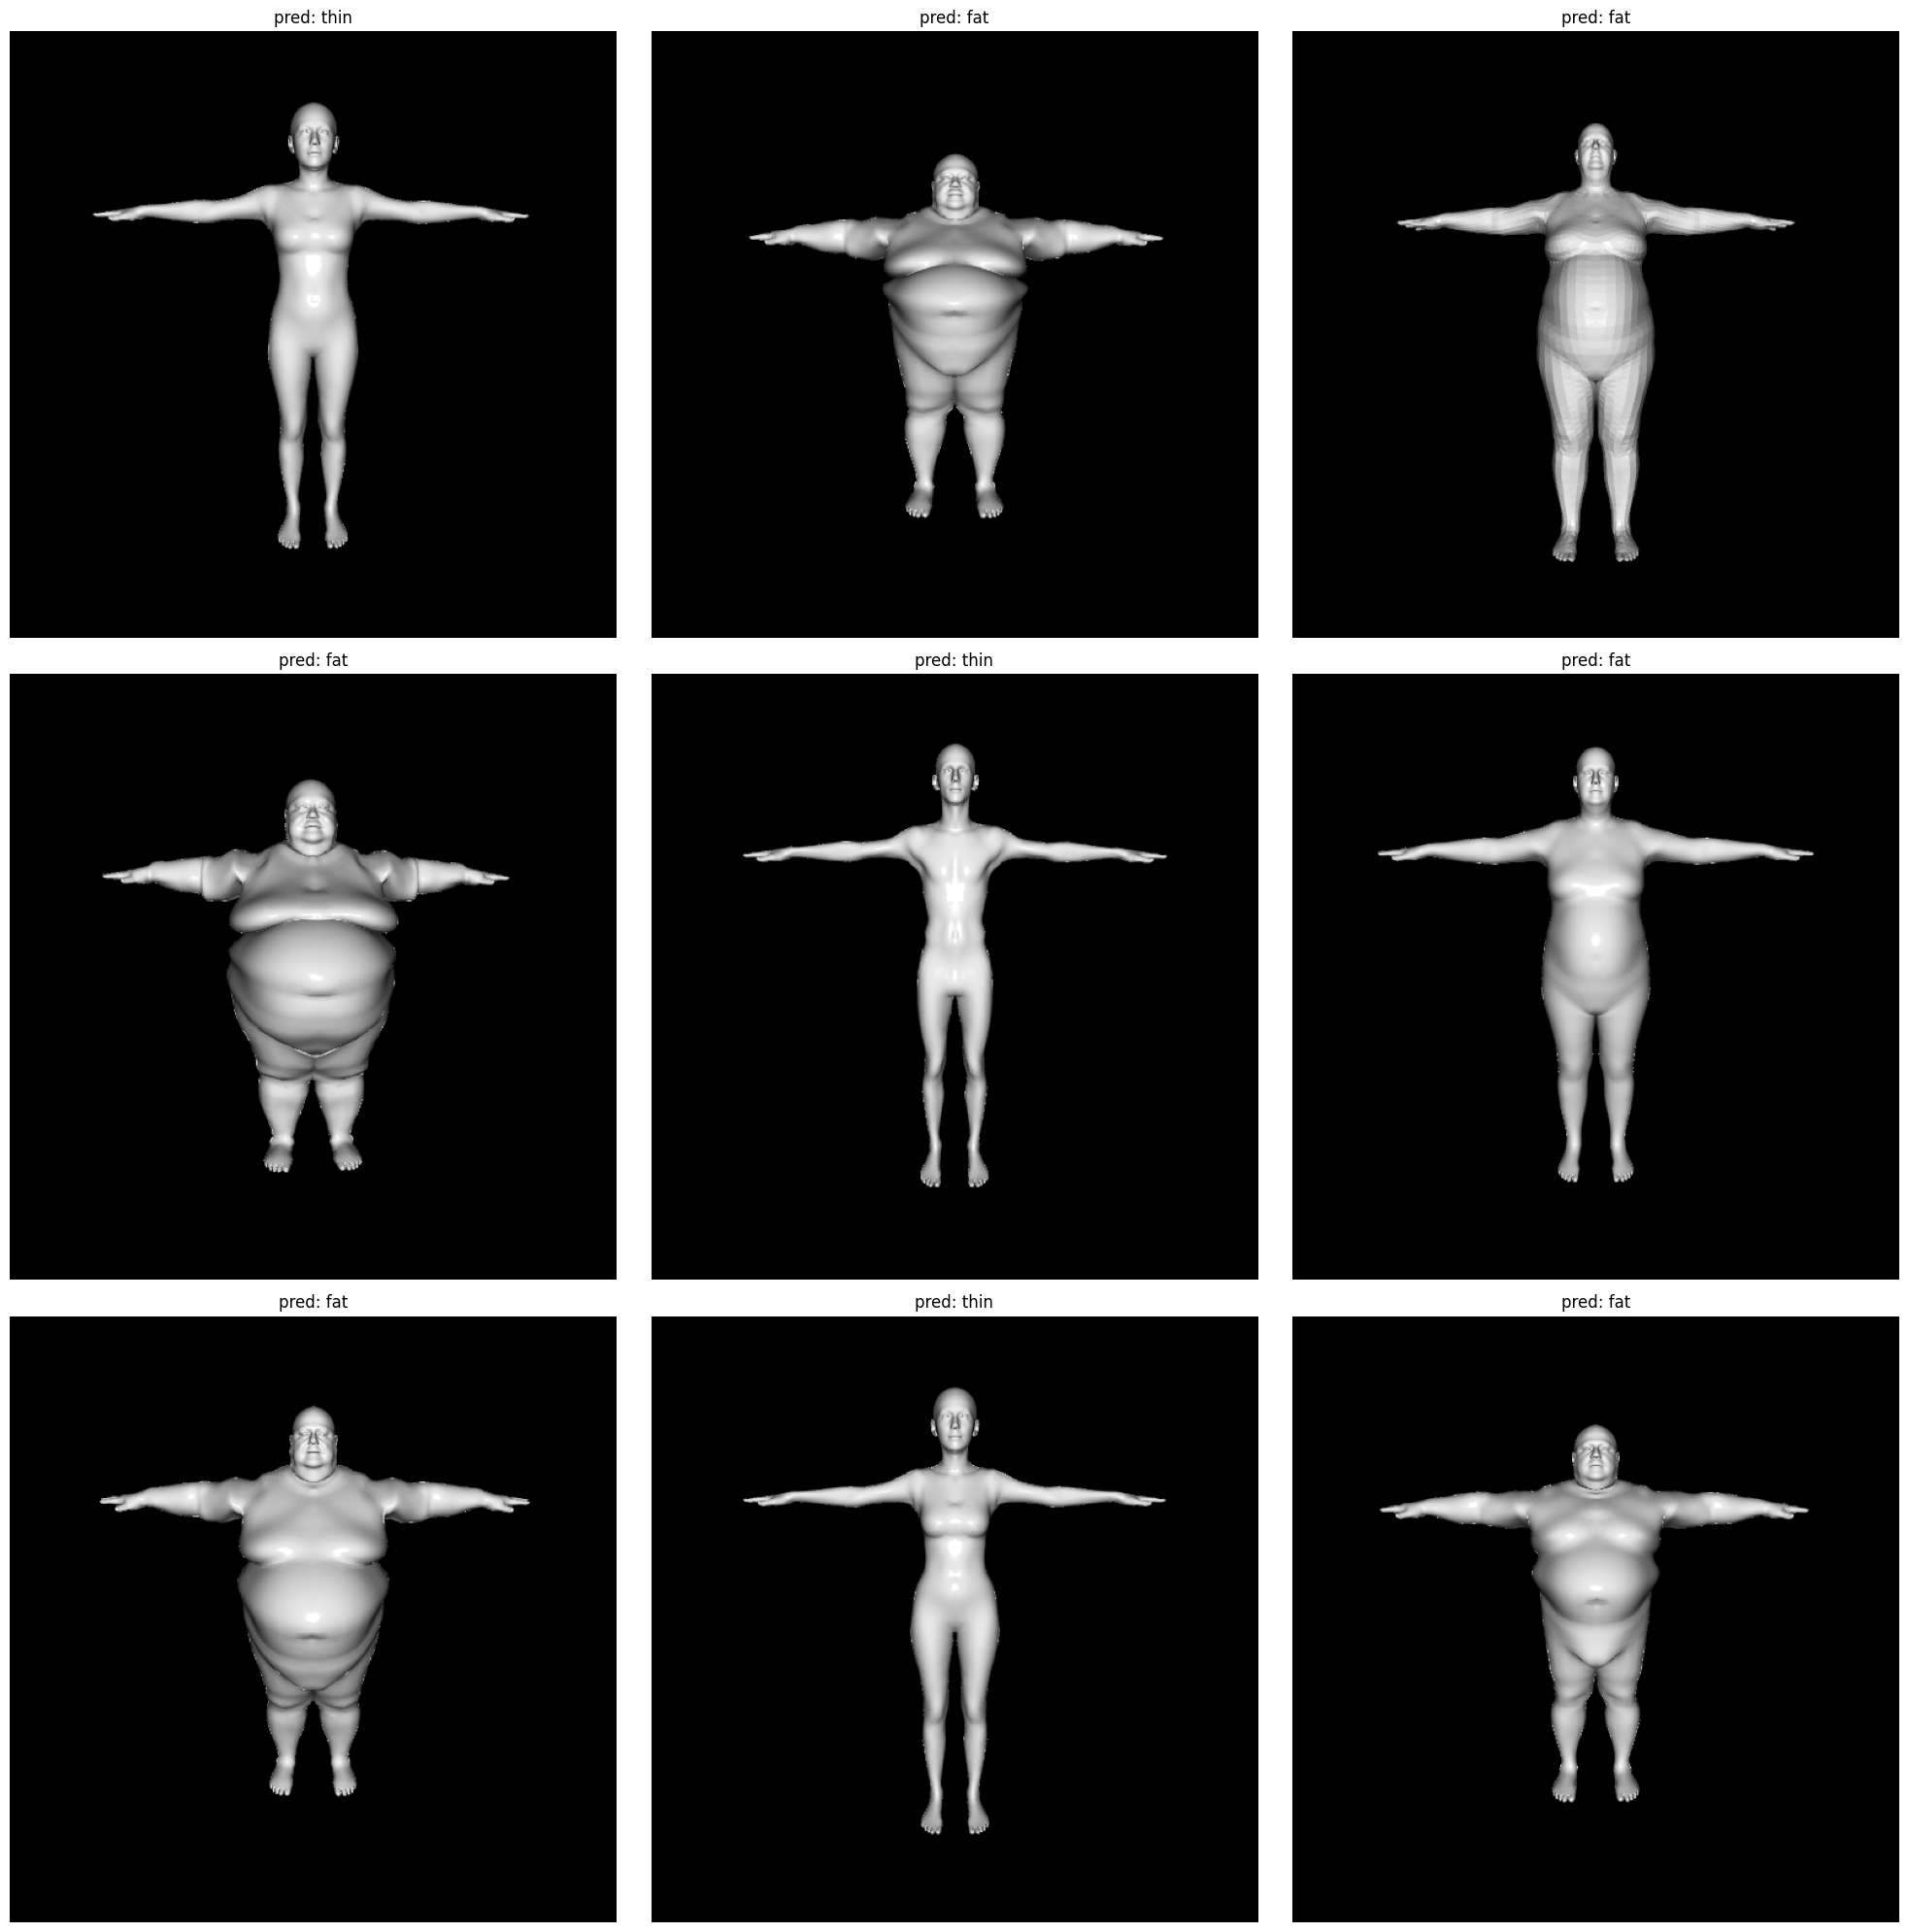

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

imgs_dir = "/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/test/"

mapping = {"fat": [], "thin": []}
predictions = {}
images = {}
imgs_to_display = {}
for file in Path(imgs_dir).iterdir():
    if file.suffix == ".png":
        images[file.stem] = preprocess(Image.open(file.as_posix())).unsqueeze(0).to(device)
        imgs_to_display[file.stem] = cv2.cvtColor(cv2.imread(file.as_posix()), cv2.COLOR_BGR2RGB)

labels = [
            "fat",
            "thin",
         ]
         

text = clip.tokenize(labels).to(device)

with torch.no_grad():
  
    for image_name, image in images.items():
        logits_per_image, logits_per = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        relevant_description = [labels[i] for i in np.where((probs > 0.2)[0])[0]]
        predictions[image_name] = labels[probs.argmax()]
        mapping[predictions[image_name]].append(image_name)

num_rows, num_columns = get_shape(images.keys().__len__())[0]

if num_rows > num_columns:
    columns = copy(num_columns)
    num_columns = num_rows
    num_rows = columns


fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 20))
row = 0
col = 0
for image_name, image in imgs_to_display.items():
    axes[row, col].imshow(image)
    axes[row, col].set_title(f"pred: {predictions[image_name]}")
    axes[row, col].axis("off")
    col += 1
    if col + 1 > num_columns:
        row += 1
        col = 0 

fig.tight_layout()

In [11]:
fig.savefig("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/predictions/predictions_1.png")

### Create Metadata to Image

In [36]:
imgs_dir  = "/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/with_expression"
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

weight_labels = ['fat']
height_labels = ['big']
happy_labels = ['happy']
angry_labels = ['angry']
big_head_labels = ['big_head']
open_mouth_labels = ['open_mouth']


weight_text = clip.tokenize(weight_labels).to(device)
height_text = clip.tokenize(height_labels).to(device)
happy_text = clip.tokenize(happy_labels).to(device)
angry_text = clip.tokenize(angry_labels).to(device)
big_head_text = clip.tokenize(big_head_labels).to(device)
open_mouth_text = clip.tokenize(open_mouth_labels).to(device)


for file in Path(imgs_dir).iterdir():
    if file.suffix == ".png":
        
        image = preprocess(Image.open(file.as_posix())).unsqueeze(0).to(device)
        
        with torch.no_grad():
        
            weight_logits_per_image, _ = model(image, weight_text)
            height_logits_per_image, _ = model(image, height_text)
            happy_logits_per_image, _ = model(image, happy_text)
            angry_logits_per_image, _ = model(image, angry_text)
            big_head_logits_per_image, _ = model(image, big_head_text)
            open_mouth_logits_per_image, _ = model(image, open_mouth_text)


            weight_probs = weight_logits_per_image.cpu().numpy()
            height_probs = height_logits_per_image.cpu().numpy()
            happy_probs = happy_logits_per_image.cpu().numpy()
            angry_probs = angry_logits_per_image.cpu().numpy()
            big_head_probs = big_head_logits_per_image.cpu().numpy()
            open_mouth_probs = open_mouth_logits_per_image.cpu().numpy()

            json_data = {'gt': [weight_probs.tolist(), height_probs.tolist(), happy_probs.tolist(), angry_probs.tolist(), big_head_probs.tolist(), open_mouth_probs.tolist()]}
            with open(file.with_suffix(".json").as_posix().replace('.json', "_labels.json"), 'w') as f:
                json.dump(json_data, f)


In [32]:
from pathlib import Path
imgs_dir  = "/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/with_expression"
for file in Path(imgs_dir).iterdir():
    print(file.with_suffix(".json").as_posix().replace('.json', "_labels.json"))
    break


/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/with_expression/56_labels.json


### Dataset & Model

In [83]:
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset


class SMPLXDataset(Dataset):

    def __init__(
        self,
        data_dir: str
        ):

        self.data_dir = data_dir
        self.files = [file for file in Path(data_dir).iterdir() if file.suffix == ".png"]
        self.files.sort()

    def __len__(self):
        return self.files.__len__()

    def __getitem__(self, idx):
        # extract parameters
        parameters_json = self.files[idx].with_suffix(".json")
        with open(parameters_json.as_posix(), 'r') as f:
            parameters = json.load(f)
        betas = torch.tensor(parameters['betas'])
        expression = torch.tensor(parameters['expression'])
        parameters_t = torch.cat((betas, expression))
        
        # extract labels
        clip_scores_json = self.files[idx].with_suffix(".json").as_posix().replace('.json', "_labels.json")
        with open(clip_scores_json, 'r') as f:
            clip_scores = json.load(f)
        labels = torch.tensor(clip_scores['gt'])[..., 0, 0]
        return parameters_t, labels

class SMPLXModel(nn.Module):

    def __init__(self, num_stats: int = 2):
        super().__init__()
        self.fc1 = nn.Linear(num_stats, 50)
        self.fc2 = nn.Linear(50, 300)
        self.fc3 = nn.Linear(300, 300)
        self.fc4 = nn.Linear(300, 20)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [91]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
batch_size = 20
dataloader = DataLoader(SMPLXDataset("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/with_expression"), batch_size=batch_size, shuffle=True)
model = SMPLXModel(num_stats=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(5000):
    for parameters, clip_labels in dataloader:
        parameters, clip_labels = parameters.to(device), clip_labels.to(device)
        optimizer.zero_grad()
        b = parameters.shape[0]
        pred = model(clip_labels).reshape(b, 2, 10)
        loss = criterion(pred, parameters)
        loss.backward()
        optimizer.step()
    # print(f"epoch: {epoch}, loss: {loss.item()}")
    writer.add_scalar("Loss/train", loss.item(), epoch)

torch.save(model.state_dict(), "/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/models/model_1.ckpt")
writer.close()

In [19]:
weights = torch.linspace(22, 29, 10).float()
heigths = torch.linspace(23, 26, 10).float()

betas = []
for weight, height in zip(weights, heigths):
    stats = torch.tensor([weight, height]).unsqueeze(0).to(device)
    pred = model(stats)
    betas.append(pred.cpu().detach().numpy()[0])

In [106]:
# evaluate
model = SMPLXModel(num_stats=6).to(device)
model.load_state_dict(torch.load("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/models/model_1.ckpt"))
model.eval()

with torch.no_grad():
# weight, height, happy, angry, big_head, open_mouth
    model(torch.tensor([22.8, 22.5, 19.4, 19.0, 22.2, 23.8]).to(device)).reshape(2, 10)

tensor([[ 6.4949, -1.8805,  2.4830, -0.7927, -0.3008, -2.0472,  3.2997,  5.7375,
         -4.3203,  4.9260],
        [-0.2274, -0.1775,  2.6528,  3.5914, -0.6832,  0.6499, -1.5133,  2.6134,
          0.0993, -1.8144]], device='cuda:0', grad_fn=<ViewBackward>)

In [4]:
import numpy as np
from pathlib import Path
import json

imgs_dir = "/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/with_texture"
stats = {}

for file in Path(imgs_dir).rglob("*_labels.json"):
    with open(file.as_posix(), "r") as f:
        data = json.load(f)
    for key, value in data.items():
        if key not in stats:
            stats[key] = []
        stats[key].append(value)

for key, value in stats.items():
    stats[key] = np.array(value)
    # show min and max
    print(f"{key}: {stats[key].min()}, {stats[key].max()}")

fat: 23.34375, 29.703125
long legs: 17.84375, 25.9375
narrow waist: 23.953125, 27.28125
big head: 20.765625, 24.109375
slim hands: 22.984375, 26.640625
Pear Shaped: 20.53125, 26.234375
skinny legs: 19.484375, 26.234375
muscular: 21.359375, 26.421875
happy: 19.984375, 23.484375


In [24]:
# create gif from images
import imageio
imgs_dir = '/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/outs'
images = []
for file in sorted(list(Path(imgs_dir).iterdir()), key=lambda x: int(x.stem)):
    if file.suffix == ".png":
        images.append(imageio.imread(file.as_posix()))

# set fps
imageio.mimsave('/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/outs.gif', images, fps=3)

/tmp/ipykernel_30081/160538541.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file.as_posix()))


### Change SMPLX pose

In [3]:
import torch
import smplx
import numpy as np
from scipy.spatial.transform import Rotation as R

pose = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4191655218601227, -0.712470531463623, -1.1537145376205444, 0.39996394515037537, 0.4775800108909607, 1.1736230850219727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
body_pose = pose.reshape(-1, 3)[1:22]
left_hand_pose = pose.reshape(-1,3)[25:40]
right_hand_pose = pose.reshape(-1,3)[40:55]
body_pose = torch.FloatTensor([R.from_rotvec(r).as_matrix() for r in body_pose]).unsqueeze(0)
left_hand_pose = torch.FloatTensor([R.from_rotvec(r).as_matrix() for r in left_hand_pose]).unsqueeze(0)
right_hand_pose = torch.FloatTensor([R.from_rotvec(r).as_matrix() for r in right_hand_pose]).unsqueeze(0)

smplx_layer = smplx.build_layer(model_path="/home/nadav2/dev/repos/CGmocap/mocap/3d_models/SMPLX_NEUTRAL_2020.npz")
smplx_out = smplx_layer(body_pose=body_pose, left_hand_pose=left_hand_pose, right_hand_pose=right_hand_pose)
body_verts = smplx_out.vertices.detach().cpu().numpy().squeeze()

In [23]:
np.save("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/SMPLX/rest_pose.npy", body_pose)

In [25]:
torch.tensor(np.load("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/SMPLX/rest_pose.npy")).shape

torch.Size([1, 21, 3, 3])

In [16]:
import json
import torch
import numpy as np
with open('/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/test.json', "r") as f:
    clip_scores = json.load(f)
torch.as_tensor(list(clip_scores.values()))[..., 0, 0]

tensor([25.5156, 22.0312, 18.2812, 21.5000])

In [26]:
for file in Path("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/with_expression").rglob("*body_labels.json"):
    file.unlink()

In [50]:
body_labels = [["fat"], ["long legs"]]
face_labels = [["smiling"], ["sad"], ["angry"]]
labels = {"body": body_labels, "face": face_labels}

In [51]:
cat_labels = []
for label in labels.values():
    cat_labels.extend(label)

In [53]:
cat_labels.__len__()

5

In [63]:
for file in Path("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/with_expression").rglob("*_face.png"):
    if not file.with_name(file.stem.replace("face", "body") + ".png").exists():
        file.unlink()
        json_path = file.with_name(file.stem.replace("_face", "") + ".json")
        json_path.unlink()

In [75]:
def wrapper(*args, **kwargs):
    return print(args[0](1, 2))

@wrapper
def sum(a, b):
    return a + b

3


In [2]:
# rename all images in a folder from "*.png" to "*_body.png"
from pathlib import Path
for file in Path("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/with_texture").rglob("*.png"):
    file.rename(file.with_name(file.name.replace(".png", "_body.png")))

In [2]:
import torch
ckpt = torch.load("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/models/best_model.ckpt")

In [8]:
ckpt.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])

In [1]:
from utils import Utils


Utils().get_labels()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


{'body': [['fat'],
  ['long legs'],
  ['narrow waist'],
  ['big head'],
  ['slim hands'],
  ['Pear Shaped'],
  ['skinny legs'],
  ['muscular']]}

In [5]:
import torch
torch.load("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/production/production_model.ckpt")['state_dict'].keys()

odict_keys(['model.fc1.weight', 'model.fc1.bias', 'model.fc5.weight', 'model.fc5.bias'])

In [49]:
import numpy as np
import torch
import torch.nn as nn
import pickle
from smplx.lbs import lbs, batch_rodrigues, vertices2landmarks, find_dynamic_lmk_idx_and_bcoords
from smplx.utils import Struct, to_tensor, to_np, rot_mat_to_euler


class FLAME(nn.Module):
    """
    Given flame parameters this class generates a differentiable FLAME function
    which outputs the a mesh and 3D facial landmarks
    """
    def __init__(self, config):
        super(FLAME, self).__init__()
        print("creating the FLAME Decoder")
        with open(config.flame_model_path, 'rb') as f:
            self.flame_model = Struct(**pickle.load(f, encoding='latin1'))
        self.NECK_IDX = 1
        self.batch_size = config.batch_size
        self.dtype = torch.float32
        self.use_face_contour = config.use_face_contour
        self.faces = self.flame_model.f
        self.register_buffer('faces_tensor',
                             to_tensor(to_np(self.faces, dtype=np.int64),
                                       dtype=torch.long))

        # Fixing remaining Shape betas
        # There are total 300 shape parameters to control FLAME; But one can use the first few parameters to express
        # the shape. For example 100 shape parameters are used for RingNet project 
        default_shape = torch.zeros([self.batch_size, 300-config.shape_params],
                                            dtype=self.dtype, requires_grad=False)
        self.register_parameter('shape_betas', nn.Parameter(default_shape,
                                                      requires_grad=False))

        # Fixing remaining expression betas
        # There are total 100 shape expression parameters to control FLAME; But one can use the first few parameters to express
        # the expression. For example 50 expression parameters are used for RingNet project 
        default_exp = torch.zeros([self.batch_size, 100 - config.expression_params],
                                    dtype=self.dtype, requires_grad=False)
        self.register_parameter('expression_betas', nn.Parameter(default_exp,
                                                            requires_grad=False))

        # Eyeball and neck rotation
        default_eyball_pose = torch.zeros([self.batch_size, 6],
                                    dtype=self.dtype, requires_grad=False)
        self.register_parameter('eye_pose', nn.Parameter(default_eyball_pose,
                                                            requires_grad=False))

        default_neck_pose = torch.zeros([self.batch_size, 3],
                                    dtype=self.dtype, requires_grad=False)
        self.register_parameter('neck_pose', nn.Parameter(default_neck_pose,
                                                            requires_grad=False))

        # Fixing 3D translation since we use translation in the image plane

        self.use_3D_translation = config.use_3D_translation

        default_transl = torch.zeros([self.batch_size, 3],
                                     dtype=self.dtype, requires_grad=False)
        self.register_parameter(
            'transl',
            nn.Parameter(default_transl, requires_grad=False))

        # The vertices of the template model
        self.register_buffer('v_template',
                             to_tensor(to_np(self.flame_model.v_template),
                                       dtype=self.dtype))

        # The shape components
        shapedirs = self.flame_model.shapedirs
        # The shape components
        self.register_buffer(
            'shapedirs',
            to_tensor(to_np(shapedirs), dtype=self.dtype))

        j_regressor = to_tensor(to_np(
            self.flame_model.J_regressor), dtype=self.dtype)
        self.register_buffer('J_regressor', j_regressor)

        # Pose blend shape basis
        num_pose_basis = self.flame_model.posedirs.shape[-1]
        posedirs = np.reshape(self.flame_model.posedirs, [-1, num_pose_basis]).T
        self.register_buffer('posedirs',
                             to_tensor(to_np(posedirs), dtype=self.dtype))

        # indices of parents for each joints
        parents = to_tensor(to_np(self.flame_model.kintree_table[0])).long()
        parents[0] = -1
        self.register_buffer('parents', parents)

        self.register_buffer('lbs_weights',
                             to_tensor(to_np(self.flame_model.weights), dtype=self.dtype))

        # Static and Dynamic Landmark embeddings for FLAME

        with open(config.static_landmark_embedding_path, 'rb') as f:
            static_embeddings = Struct(**pickle.load(f, encoding='latin1'))

        lmk_faces_idx = (static_embeddings.lmk_face_idx).astype(np.int64)
        self.register_buffer('lmk_faces_idx',
                             torch.tensor(lmk_faces_idx, dtype=torch.long))
        lmk_bary_coords = static_embeddings.lmk_b_coords
        self.register_buffer('lmk_bary_coords',
                             torch.tensor(lmk_bary_coords, dtype=self.dtype))

        if self.use_face_contour:
            conture_embeddings = np.load(config.dynamic_landmark_embedding_path,
                allow_pickle=True, encoding='latin1')
            conture_embeddings = conture_embeddings[()]
            dynamic_lmk_faces_idx = np.array(conture_embeddings['lmk_face_idx']).astype(np.int64)
            dynamic_lmk_faces_idx = torch.tensor(
                dynamic_lmk_faces_idx,
                dtype=torch.long)
            self.register_buffer('dynamic_lmk_faces_idx',
                                 dynamic_lmk_faces_idx)

            dynamic_lmk_bary_coords = conture_embeddings['lmk_b_coords']
            dynamic_lmk_bary_coords = torch.tensor(
                dynamic_lmk_bary_coords, dtype=self.dtype)
            self.register_buffer('dynamic_lmk_bary_coords',
                                 dynamic_lmk_bary_coords)

            neck_kin_chain = []
            curr_idx = torch.tensor(self.NECK_IDX, dtype=torch.long)
            while curr_idx != -1:
                neck_kin_chain.append(curr_idx)
                curr_idx = self.parents[curr_idx]
            self.register_buffer('neck_kin_chain',
                                 torch.stack(neck_kin_chain))

    def _find_dynamic_lmk_idx_and_bcoords(self, vertices, pose, dynamic_lmk_faces_idx,
                                         dynamic_lmk_b_coords,
                                         neck_kin_chain, dtype=torch.float32):
        """
            Selects the face contour depending on the reletive position of the head
            Input:
                vertices: N X num_of_vertices X 3
                pose: N X full pose
                dynamic_lmk_faces_idx: The list of contour face indexes
                dynamic_lmk_b_coords: The list of contour barycentric weights
                neck_kin_chain: The tree to consider for the relative rotation
                dtype: Data type
            return:
                The contour face indexes and the corresponding barycentric weights
            Source: Modified for batches from https://github.com/vchoutas/smplx
        """

        batch_size = vertices.shape[0]

        aa_pose = torch.index_select(pose.view(batch_size, -1, 3), 1,
                                     neck_kin_chain)
        rot_mats = batch_rodrigues(
            aa_pose.view(-1, 3), dtype=dtype).view(batch_size, -1, 3, 3)

        rel_rot_mat = torch.eye(3, device=vertices.device,
                                dtype=dtype).unsqueeze_(dim=0).expand(batch_size, -1, -1)
        for idx in range(len(neck_kin_chain)):
            rel_rot_mat = torch.bmm(rot_mats[:, idx], rel_rot_mat)

        y_rot_angle = torch.round(
            torch.clamp(-rot_mat_to_euler(rel_rot_mat) * 180.0 / np.pi,
                        max=39)).to(dtype=torch.long)
        neg_mask = y_rot_angle.lt(0).to(dtype=torch.long)
        mask = y_rot_angle.lt(-39).to(dtype=torch.long)
        neg_vals = mask * 78 + (1 - mask) * (39 - y_rot_angle)
        y_rot_angle = (neg_mask * neg_vals +
                       (1 - neg_mask) * y_rot_angle)

        dyn_lmk_faces_idx = torch.index_select(dynamic_lmk_faces_idx,
                                               0, y_rot_angle)
        dyn_lmk_b_coords = torch.index_select(dynamic_lmk_b_coords,
                                              0, y_rot_angle)

        return dyn_lmk_faces_idx, dyn_lmk_b_coords

    def forward(self, shape_params=None, expression_params=None, pose_params=None, neck_pose=None, eye_pose=None, transl=None):
        """
            Input:
                shape_params: N X number of shape parameters
                expression_params: N X number of expression parameters
                pose_params: N X number of pose parameters
            return:
                vertices: N X V X 3
                landmarks: N X number of landmarks X 3
        """
        betas = torch.cat([shape_params,self.shape_betas, expression_params, self.expression_betas], dim=1)
        neck_pose = (neck_pose if neck_pose is not None else self.neck_pose)
        eye_pose = (eye_pose if eye_pose is not None else self.eye_pose)
        transl = (transl if transl is not None else self.transl)
        full_pose = torch.cat([pose_params[:,:3], neck_pose, pose_params[:,3:], eye_pose], dim=1)
        template_vertices = self.v_template.unsqueeze(0).repeat(self.batch_size, 1, 1)

        vertices, _ = lbs(betas, full_pose, template_vertices,
                               self.shapedirs, self.posedirs,
                               self.J_regressor, self.parents,
                               self.lbs_weights)

        lmk_faces_idx = self.lmk_faces_idx.unsqueeze(dim=0).repeat(
            self.batch_size, 1)
        lmk_bary_coords = self.lmk_bary_coords.unsqueeze(dim=0).repeat(
            self.batch_size, 1, 1)
        if self.use_face_contour:

            dyn_lmk_faces_idx, dyn_lmk_bary_coords = self._find_dynamic_lmk_idx_and_bcoords(
                vertices, full_pose, self.dynamic_lmk_faces_idx,
                self.dynamic_lmk_bary_coords,
                self.neck_kin_chain, dtype=self.dtype)

            lmk_faces_idx = torch.cat([dyn_lmk_faces_idx, lmk_faces_idx], 1)
            lmk_bary_coords = torch.cat(
                [dyn_lmk_bary_coords, lmk_bary_coords], 1)

        landmarks = vertices2landmarks(vertices, self.faces_tensor,
                                             lmk_faces_idx,
                                             lmk_bary_coords)

        if self.use_3D_translation:
            landmarks += transl.unsqueeze(dim=1)
            vertices += transl.unsqueeze(dim=1)

        return vertices, landmarks

In [50]:
flame_model_path = "/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/Flame/flame2020/generic_model.pkl"
static_landmark_embedding_path = "/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/Flame/flame2020/flame_static_embedding_68.pkl"

In [53]:
from attrdict import AttrDict

config = AttrDict()
batch_size = 1
use_face_contour = False
use_3D_translation = True
dtype = torch.float32
device = torch.device("cpu")
shape_params = 100
expression_params = 50
flame_model_path = flame_model_path
ring_margin = 0.5
ring_loss_weight = 1.0
static_landmark_embedding_path = static_landmark_embedding_path
pose_params = 6


In [57]:
import numpy as np
import torch
import trimesh

radian = np.pi/180.0
flamelayer = FLAME(config)

# Creating a batch of mean shapes
shape_params = torch.zeros(1, 100).cuda()

# Creating a batch of different global poses
# pose_params_numpy[:, :3] : global rotaation
# pose_params_numpy[:, 3:] : jaw rotaation
pose_params_numpy = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=np.float32)
pose_params = torch.tensor(pose_params_numpy, dtype=torch.float32).cuda()

# Cerating a batch of neutral expressions
expression_params = torch.zeros(1, 50, dtype=torch.float32).cuda()
flamelayer.cuda()

# Forward Pass of FLAME, one can easily use this as a layer in a Deep learning Framework 
vertice, landmark = flamelayer(shape_params, expression_params, pose_params)

creating the FLAME Decoder


/tmp/ipykernel_16063/3550675401.py:18: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  self.flame_model = Struct(**pickle.load(f, encoding='latin1'))


In [ ]:
from pytorch3d.io import save_obj



In [62]:
np.save("/home/nadav2/Documents/Test/vertice.npy", vertice.cpu().numpy())

In [65]:
np.save("/home/nadav2/Documents/Test/faces.npy", flamelayer.faces)

In [1]:
len(['index1', 'index2', 'index3', 'middle1', 'middle2', 'middle3', 'pinky1', 'pinky2', 'pinky3', 'ring1', 'ring2', 'ring3', 'thumb1', 'thumb2', 'thumb3'])

15

In [13]:
import numpy as np
texture_data_file = "/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/Flame/flame2020/texture_data_512_flamepp.npy"
np.load(texture_data_file, allow_pickle=True).tolist()['vt']

array([[0.868966, 0.478799],
       [0.868199, 0.477677],
       [0.869033, 0.47841 ],
       ...,
       [0.024712, 0.851023],
       [0.058888, 0.921728],
       [0.0345  , 0.845364]], dtype=float32)

In [31]:
from plyfile import PlyData, PlyElement
import numpy as np

class myMesh(object):
    """
    Attributes:
        v: Vx3 array of vertices
        f: Fx3 array of faces
    """
    def __init__(self, v=None, f=None, filename=None):
        self.v = None
        self.f = None

        if v is not None:
            self.v = np.array(v, dtype=np.float64)
        if f is not None:
            self.f = np.require(f, dtype=np.uint32)

        if filename is not None:
            self.load_from_ply(filename)

        self.vn = None
        self.fn = None
        self.vf = None
        self.v_indexed_by_faces = None
        self.vc = np.array([1.0, 0.0, 0.0])

    def load_from_ply(self, filename):

        plydata = PlyData.read(filename)
        self.plydata = plydata

        self.f = np.vstack(plydata['face'].data['vertex_indices'])
        x = plydata['vertex'].data['x']
        y = plydata['vertex'].data['y']
        z = plydata['vertex'].data['z']
        self.v = np.zeros([x.size, 3])
        self.v[:,0] = x
        self.v[:,1] = y
        self.v[:,2] = z


    def save_ply(self, filename):

        vertex = np.array([tuple(i) for i in self.v], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])
        face = np.array([(tuple(i), 255, 255, 255) for i in self.f] , 
            dtype=[('vertex_indices', 'i4', (3,)),
            ('red', 'u1'), ('green', 'u1'),
            ('blue', 'u1')])
        el = PlyElement.describe(vertex, 'vertex')
        el2 = PlyElement.describe(face, 'face')
        plydata = PlyData([el, el2])
        plydata.write(filename)

import pickle
from smplx.utils import Struct
smal_model_path = "/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/SMAL/smal_CVPR2017.pkl"
with open(smal_model_path, 'rb') as f:
    smal_model = pickle.load(f, encoding='latin1')
# Save the mean model
# model.r are the model vertexes, and model.f are the mesh faces.
m = myMesh(v=smal_model["v_template"], f=smal_model["f"])
# m.save_ply('/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/SMAL/smal_mean_shape.ply')
m.v

/tmp/ipykernel_12431/2893463314.py:59: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  smal_model = pickle.load(f, encoding='latin1')


array([[-8.73739497e-01,  1.02025831e-04,  2.36372171e-01],
       [ 4.57527733e-01,  1.02025831e-04,  4.45425090e-01],
       [-1.07022834e-02,  1.02025831e-04, -1.51154606e-01],
       ...,
       [ 3.82883721e-01, -7.08975153e-02, -4.22343834e-01],
       [ 3.79902060e-01, -8.29590935e-02, -4.01230794e-01],
       [ 3.71702500e-01, -7.05266471e-02, -4.01951949e-01]])

In [36]:
import pickle
from smplx.utils import Struct
smal_model_path = "/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/SMAL/smal_CVPR2017.pkl"
with open(smal_model_path, 'rb') as f:
    smal_model = pickle.load(f, encoding='latin1')
print(smal_model.keys())
smal_model["posedirs"].shape

dict_keys(['f', 'J_regressor', 'kintree_table', 'J', 'bs_style', 'weights', 'posedirs', 'v_template', 'shapedirs', 'bs_type'])


/tmp/ipykernel_12431/3734593854.py:5: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  smal_model = pickle.load(f, encoding='latin1')


(3889, 3, 288)

In [ ]:
import numpy as np

unity_data = np.load("betas_shape_family_1_edit.npy")
unity_data[[2,7,11], 22] = -1.0
unity_data[[2,7,11], 23] = 0.0
# unity_data[:, 20:] = np.exp(unity_data[:, 20:])
        
model_covs = np.cov(unity_data, rowvar=False)
mean_betas_unimode = np.mean(unity_data, axis = 0)

np.savez_compressed('unity_betas.npz', 
    cov = model_covs,
    mean = mean_betas_unimode,
    models = unity_data)

In [93]:
import numpy as np
import torch
from torch.autograd import Variable
import pickle as pkl 
import torch.nn as nn
import config


def batch_skew(vec, batch_size=None, opts=None):
    """
    vec is N x 3, batch_size is int
    returns N x 3 x 3. Skew_sym version of each matrix.
    """
    if batch_size is None:
        batch_size = vec.shape.as_list()[0]
    col_inds = torch.LongTensor([1, 2, 3, 5, 6, 7])
    indices = torch.reshape(torch.reshape(torch.arange(0, batch_size) * 9, [-1, 1]) + col_inds, [-1, 1])
    updates = torch.reshape(
            torch.stack(
                [
                    -vec[:, 2], vec[:, 1], vec[:, 2], -vec[:, 0], -vec[:, 1],
                    vec[:, 0]
                ],
                dim=1), [-1])
    out_shape = [batch_size * 9]
    res = torch.Tensor(np.zeros(out_shape[0])).to(device=vec.device)
    res[np.array(indices.flatten())] = updates
    res = torch.reshape(res, [batch_size, 3, 3])

    return res

def batch_rodrigues(theta, opts=None):
    """
    Theta is Nx3
    """
    batch_size = theta.shape[0]

    angle = (torch.norm(theta + 1e-8, p=2, dim=1)).unsqueeze(-1)
    r = (torch.div(theta, angle)).unsqueeze(-1)

    angle = angle.unsqueeze(-1)
    cos = torch.cos(angle)
    sin = torch.sin(angle)

    outer = torch.matmul(r, r.transpose(1,2))

    eyes = torch.eye(3).unsqueeze(0).repeat([batch_size, 1, 1]).to(device=theta.device)
    H = batch_skew(r, batch_size=batch_size, opts=opts)
    R = cos * eyes + (1 - cos) * outer + sin * H 

    return R

def batch_lrotmin(theta):
    """
    Output of this is used to compute joint-to-pose blend shape mapping.
    Equation 9 in SMPL paper.
    Args:
      pose: `Tensor`, N x 72 vector holding the axis-angle rep of K joints.
            This includes the global rotation so K=24
    Returns
      diff_vec : `Tensor`: N x 207 rotation matrix of 23=(K-1) joints with identity subtracted.,
    """
    # Ignore global rotation
    theta = theta[:,3:]

    Rs = batch_rodrigues(torch.reshape(theta, [-1,3]))
    lrotmin = torch.reshape(Rs - torch.eye(3), [-1, 207])

    return lrotmin

def batch_global_rigid_transformation(Rs, Js, parent, rotate_base = False, betas_logscale=None, opts=None):
    """
    Computes absolute joint locations given pose.
    rotate_base: if True, rotates the global rotation by 90 deg in x axis.
    if False, this is the original SMPL coordinate.
    Args:
      Rs: N x 24 x 3 x 3 rotation vector of K joints
      Js: N x 24 x 3, joint locations before posing
      parent: 24 holding the parent id for each index
    Returns
      new_J : `Tensor`: N x 24 x 3 location of absolute joints
      A     : `Tensor`: N x 24 4 x 4 relative joint transformations for LBS.
    """
    if rotate_base:
        print('Flipping the SMPL coordinate frame!!!!')
        rot_x = torch.Tensor([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
        rot_x = torch.reshape(torch.repeat(rot_x, [N, 1]), [N, 3, 3]) # In tf it was tile
        root_rotation = torch.matmul(Rs[:, 0, :, :], rot_x)
    else:
        root_rotation = Rs[:, 0, :, :]

    # Now Js is N x 24 x 3 x 1
    Js = Js.unsqueeze(-1)
    N = Rs.shape[0]

    Js_orig = Js.clone()

    scaling_factors = torch.ones(N, parent.shape[0], 3).to(Rs.device)
    if betas_logscale is not None:
        leg_joints = list(range(7,11)) + list(range(11,15)) + list(range(17,21)) + list(range(21,25))
        tail_joints = list(range(25, 32))
        ear_joints = [33, 34]

        beta_scale_mask = torch.zeros(35, 3, 6).to(betas_logscale.device)
        beta_scale_mask[leg_joints, [2], [0]] = 1.0 # Leg lengthening
        beta_scale_mask[leg_joints, [0], [1]] = 1.0 # Leg fatness
        beta_scale_mask[leg_joints, [1], [1]] = 1.0 # Leg fatness
        
        beta_scale_mask[tail_joints, [0], [2]] = 1.0 # Tail lengthening
        beta_scale_mask[tail_joints, [1], [3]] = 1.0 # Tail fatness
        beta_scale_mask[tail_joints, [2], [3]] = 1.0 # Tail fatness
        
        beta_scale_mask[ear_joints, [1], [4]] = 1.0 # Ear y
        beta_scale_mask[ear_joints, [2], [5]] = 1.0 # Ear z

        beta_scale_mask = torch.transpose(
            beta_scale_mask.reshape(35*3, 6), 0, 1)

        betas_scale = torch.exp(betas_logscale @ beta_scale_mask)
        scaling_factors = betas_scale.reshape(-1, 35, 3)

    scale_factors_3x3 = torch.diag_embed(scaling_factors, dim1=-2, dim2=-1)

    def make_A(R, t):
        # Rs is N x 3 x 3, ts is N x 3 x 1
        R_homo = torch.nn.functional.pad(R, (0,0,0,1,0,0))
        t_homo = torch.cat([t, torch.ones([N, 1, 1]).to(Rs.device)], 1)
        return torch.cat([R_homo, t_homo], 2)
    
    A0 = make_A(root_rotation, Js[:, 0])
    results = [A0]
    for i in range(1, parent.shape[0]):
        j_here = Js[:, i] - Js[:, parent[i]]

        s_par_inv = torch.inverse(scale_factors_3x3[:, parent[i]])
        rot = Rs[:, i]
        s = scale_factors_3x3[:, i]
        
        rot_new = s_par_inv @ rot @ s

        A_here = make_A(rot_new, j_here)
        res_here = torch.matmul(
            results[parent[i]], A_here)
        
        results.append(res_here)

    # 10 x 24 x 4 x 4
    results = torch.stack(results, dim=1)

    # scale updates
    new_J = results[:, :, :3, 3]

    # --- Compute relative A: Skinning is based on
    # how much the bone moved (not the final location of the bone)
    # but (final_bone - init_bone)
    # ---
    Js_w0 = torch.cat([Js_orig, torch.zeros([N, 33, 1, 1]).to(Rs.device)], 2)
    init_bone = torch.matmul(results, Js_w0)
    # Append empty 4 x 3:
    init_bone = torch.nn.functional.pad(init_bone, (3,0,0,0,0,0,0,0))
    A = results - init_bone

    return new_J, A

# There are chumpy variables so convert them to numpy.
def undo_chumpy(x):
    return x if isinstance(x, np.ndarray) else x.r

class SMAL(nn.Module):
    def __init__(self, device, shape_family_id=-1, dtype=torch.float):
        super(SMAL, self).__init__()

        # -- Load SMPL params --
        # with open(pkl_path, 'r') as f:
        #     dd = pkl.load(f)
           
        smal_model_path = "/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/SMAL/smal_CVPR2017.pkl"
        with open(smal_model_path, 'rb') as f:
            dd = pickle.load(f, encoding='latin1')
        

        self.f = dd['f']

        self.faces = torch.from_numpy(self.f.astype(int)).to(device)

        # replaced logic in here (which requried SMPL library with L58-L68)
        # v_template = get_smal_template(
        #     model_name=config.SMAL_FILE, 
        #     data_name=config.SMAL_DATA_FILE, 
        #     shape_family_id=shape_family_id)

        v_template = dd['v_template']

        # Size of mesh [Number of vertices, 3]
        self.size = [v_template.shape[0], 3]
        self.num_betas = dd['shapedirs'].shape[-1]
        # Shape blend shape basis
        
        shapedir = np.reshape(
            undo_chumpy(dd['shapedirs']), [-1, self.num_betas]).T.copy()
        self.shapedirs = Variable(
            torch.Tensor(shapedir), requires_grad=False).to(device)

        if shape_family_id != -1:
            with open("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/SMAL/smal_CVPR2017_data.pkl", 'rb') as f:
                u = pkl._Unpickler(f)
                u.encoding = 'latin1'
                data = u.load()

            # Select mean shape for quadruped type
            betas = data['cluster_means'][shape_family_id]
            v_template = v_template + np.matmul(betas[None,:], shapedir).reshape(
                -1, self.size[0], self.size[1])[0]

        v_sym, self.left_inds, self.right_inds, self.center_inds = align_smal_template_to_symmetry_axis(
            v_template)

        # Mean template vertices
        self.v_template = Variable(
            torch.Tensor(v_sym),
            requires_grad=False).to(device)

        # Regressor for joint locations given shape 
        self.J_regressor = Variable(
            torch.Tensor(dd['J_regressor'].T.todense()),
            requires_grad=False).to(device)

        # Pose blend shape basis
        num_pose_basis = dd['posedirs'].shape[-1]
        
        posedirs = np.reshape(
            undo_chumpy(dd['posedirs']), [-1, num_pose_basis]).T
        self.posedirs = Variable(
            torch.Tensor(posedirs), requires_grad=False).to(device)

        # indices of parents for each joints
        self.parents = dd['kintree_table'][0].astype(np.int32)

        # LBS weights
        self.weights = Variable(
            torch.Tensor(undo_chumpy(dd['weights'])),
            requires_grad=False).to(device)


    def __call__(self, beta, theta, trans=None, del_v=None, betas_logscale=None, get_skin=True, v_template=None):

        if True:
            nBetas = beta.shape[1]
        else:
            nBetas = 0

        
        # v_template = self.v_template.unsqueeze(0).expand(beta.shape[0], 3889, 3)
        if v_template is None:
            v_template = self.v_template

        # 1. Add shape blend shapes
        
        if nBetas > 0:
            if del_v is None:
                v_shaped = v_template + torch.reshape(torch.matmul(beta, self.shapedirs[:nBetas,:]), [-1, self.size[0], self.size[1]])
            else:
                v_shaped = v_template + del_v + torch.reshape(torch.matmul(beta, self.shapedirs[:nBetas,:]), [-1, self.size[0], self.size[1]])
        else:
            if del_v is None:
                v_shaped = v_template.unsqueeze(0)
            else:
                v_shaped = v_template + del_v 

        # 2. Infer shape-dependent joint locations.
        Jx = torch.matmul(v_shaped[:, :, 0], self.J_regressor)
        Jy = torch.matmul(v_shaped[:, :, 1], self.J_regressor)
        Jz = torch.matmul(v_shaped[:, :, 2], self.J_regressor)
        J = torch.stack([Jx, Jy, Jz], dim=2)
        
        # 3. Add pose blend shapes
        # N x 24 x 3 x 3
        if len(theta.shape) == 4:
            Rs = theta
        else:
            Rs = torch.reshape( batch_rodrigues(torch.reshape(theta, [-1, 3])), [-1, 35, 3, 3])
        
        # Ignore global rotation.
        # pose_feature = torch.reshape(Rs[:, 1:, :, :] - torch.eye(3).to(beta.device), [-1, 288])
        pose_feature = torch.reshape(torch.zeros(1, 32, 3, 3), [-1, 288]).cuda()
        
        v_posed = torch.reshape(
            torch.matmul(pose_feature, self.posedirs),
            [-1, self.size[0], self.size[1]]) + v_shaped

        #4. Get the global joint location
        self.J_transformed, A = batch_global_rigid_transformation(
            Rs, J, self.parents, betas_logscale=betas_logscale)


        # 5. Do skinning:
        num_batch = theta.shape[0]
        
        weights_t = self.weights.repeat([num_batch, 1])
        W = torch.reshape(weights_t, [num_batch, -1, 33])

            
        T = torch.reshape(
            torch.matmul(W, torch.reshape(A, [num_batch, 33, 16])),
                [num_batch, -1, 4, 4])
        v_posed_homo = torch.cat(
                [v_posed, torch.ones([num_batch, v_posed.shape[1], 1]).to(device=beta.device)], 2)
        v_homo = torch.matmul(T, v_posed_homo.unsqueeze(-1))

        verts = v_homo[:, :, :3, 0]

        if trans is None:
            trans = torch.zeros((num_batch,3)).to(device=beta.device)

        verts = verts + trans[:,None,:]

        # Get joints:
        joint_x = torch.matmul(verts[:, :, 0], self.J_regressor)
        joint_y = torch.matmul(verts[:, :, 1], self.J_regressor)
        joint_z = torch.matmul(verts[:, :, 2], self.J_regressor)
        joints = torch.stack([joint_x, joint_y, joint_z], dim=2)

        joints = torch.cat([
            joints,
            verts[:, None, 1863], # end_of_nose
            verts[:, None, 26], # chin
            verts[:, None, 2124], # right ear tip
            verts[:, None, 150], # left ear tip
            verts[:, None, 3055], # left eye
            verts[:, None, 1097], # right eye
            ], dim = 1) 

        if get_skin:
            return verts, joints, Rs, v_shaped
        else:
            return joints

def align_smal_template_to_symmetry_axis(v):
    # These are the indexes of the points that are on the symmetry axis
    I = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 37, 55, 119, 120, 163, 209, 210, 211, 213, 216, 227, 326, 395, 452, 578, 910, 959, 964, 975, 976, 977, 1172, 1175, 1176, 1178, 1194, 1243, 1739, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1870, 1919, 1960, 1961, 1965, 1967, 2003]

    v = v - np.mean(v)
    y = np.mean(v[I,1])
    v[:,1] = v[:,1] - y
    v[I,1] = 0


    
    left = v[:, 1] < 0
    right = v[:, 1] > 0
    center = v[:, 1] == 0
    v[left[2]] = np.array([1,-1,1])*v[0]

    left_inds = np.where(left)[0]
    right_inds = np.where(right)[0]
    center_inds = np.where(center)[0]

    try:
        assert(len(left_inds) == len(right_inds))
    except:
        import pdb; pdb.set_trace()

    return v, left_inds, right_inds, center_inds

# betas = torch.zeros(1, 41).to('cuda')
rand_betas = torch.randn(1, 10) * torch.randint(-2, 2, (1, 10)).float()
betas = torch.cat([rand_betas, torch.zeros(1, 31)], 1).to('cuda')
# 24 x 3 x 3 of idel pose
theta = torch.eye(3).expand(1, 35, 3, 3).to('cuda')
smal = SMAL('cuda')(beta=betas, theta=theta)
v = smal[0]
f = smal_model['f']
np.save("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/SMAL/v.npy", v.cpu().numpy())
np.save("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/SMAL/f.npy", f)


/tmp/ipykernel_12431/3528297505.py:179: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  dd = pickle.load(f, encoding='latin1')


In [11]:
# change "params" key to "beta"

import json
from pathlib import Path
for file in Path("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/temp").rglob("*.json"):
    if "labels" not in file.stem:
        with open(file) as f:
            data = json.load(f)
        data["beta"] = data.pop("params")
        with open(file, "w") as f:
            json.dump(data, f)

In [5]:
# remove all jsons without "_new"
for file in Path("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/temp").rglob("*.json"):
    if "_new" not in file.name:
        file.unlink()

In [6]:
# replace all "_new.json" with ".json"
for file in Path("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/temp").rglob("*.json"):
    if "_new" in file.name:
        file.rename(file.parent / file.name.replace("_new", ""))

In [8]:
# add 31 zeros to the end of the betas
import json
from pathlib import Path
for file in Path("/home/nadav2/dev/data/CLIP2Shape/images/temp").rglob("*.json"):
    if "labels" not in file.stem:
        with open(file.as_posix(), 'r') as f:
            data = json.load(f)
        data['expression_params'] = [data['expression_params'][0] + [0]*31]
        with open(file.with_name(f"{file.stem}.json").as_posix(), 'w') as f:
            json.dump(data, f)

In [10]:
# remove 31 zeros from the end of the betas
import json
for file in Path("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/temp").rglob("*.json"):
    if "labels" not in file.stem:
        with open(file.as_posix(), 'r') as f:
            data = json.load(f)
        data['expression_params'] = [data['expression_params'][0][:41]]
        with open(file.with_name(f"{file.stem}.json").as_posix(), 'w') as f:
            json.dump(data, f)

In [27]:
for file in Path("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/temp").rglob("*.png"):
    unknown_file = file.with_suffix("")
    unknown_file.rename(unknown_file.with_suffix(".json"))


In [76]:
smal_model_path = "/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/SMAL/smal_CVPR2017.pkl"

with open(smal_model_path, 'rb') as f:
    smal_model = pickle.load(f, encoding='latin1')

/tmp/ipykernel_12431/2445739894.py:4: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  smal_model = pickle.load(f, encoding='latin1')


In [14]:
import shutil
from pathlib import Path
i = 1823
working_dir = "/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/saved_by_me"
tgt_dir = Path("/home/nadav2/dev/data/Thesis/Repositories/SMPLX_CLIP/images/temp")
for img in sorted(list(Path(working_dir).rglob("*.png")), key=lambda x: int(x.stem)):
    params_json_file = img.with_suffix(".json")
    labels_json_file = img.with_name(img.name.replace(".png", "_labels.json"))

    shutil.copy(img, tgt_dir / f"{i}.png")
    shutil.copy(params_json_file, tgt_dir / f"{i}.json")
    shutil.copy(labels_json_file, tgt_dir / f"{i}_labels.json")
    i += 1


In [ ]:
# copy all files 

In [3]:
import torch
torch.zeros((40)).tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [49]:
import torch
import clip
cos_sim = torch.nn.functional.l1_loss
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
label_1 = clip.tokenize(['fat']).to(device)
label_2 = clip.tokenize(['skinny']).to(device)
label_3 = clip.tokenize(['long legs']).to(device)
label_4 = clip.tokenize(['short legs']).to(device)
sentence = clip.tokenize(['a skinny and short person with a fat body']).to(device)
for label in [label_1, label_2, label_3, label_4]:
    print(cos_sim(label.float(), sentence.float()))

tensor(1334.6364, device='cuda:0')
tensor(1464.1559, device='cuda:0')
tensor(1579.0779, device='cuda:0')
tensor(1598.1299, device='cuda:0')


In [27]:
from sentence_transformers import SentenceTransformer
from torch.nn.functional import cosine_similarity
from utils import Utils
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
utils = Utils()
labels = utils.flatten_list_of_lists(utils.get_labels())

INFO - 2022-11-29 10:55:44,487 - SentenceTransformer - Load pretrained SentenceTransformer: paraphrase-MiniLM-L6-v2
INFO - 2022-11-29 10:55:44,741 - SentenceTransformer - Use pytorch device: cuda


In [30]:
def normalize_data(data):
    for key, value in data.items():
        min_val, max_val = 0.2, 0.7
        data[key] = (value - min_val) / (max_val - min_val)
    return data

In [31]:
sentence = ['a thin lady']
labels_embeddings = model.encode(labels, convert_to_tensor=True, show_progress_bar=True)
sentence_embedding = model.encode(sentence, convert_to_tensor=True, show_progress_bar=True)
for label_name, label_embedding in zip(labels, labels_embeddings):
    print(label_name, cosine_similarity(sentence_embedding, label_embedding.unsqueeze(0)).item())
    print("normalized:", normalize_data({label_name: cosine_similarity(sentence_embedding, label_embedding.unsqueeze(0)).item()}))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

fat 0.29491984844207764
normalized: {'fat': 0.18983969688415528}
long legs 0.24669937789440155
normalized: {'long legs': 0.09339875578880309}
narrow waist 0.46406927704811096
normalized: {'narrow waist': 0.528138554096222}
pear-shaped 0.14558595418930054
normalized: {'pear-shaped': -0.10882809162139896}
muscular 0.2440376728773117
normalized: {'muscular': 0.0880753457546234}
female 0.615252673625946
normalized: {'female': 0.8305053472518922}


In [10]:
min_max_dict = utils.get_min_max_values("/home/nadav2/dev/data/CLIP2Shape/images/with_texture")

In [11]:
min_max_dict

{'fat': (23.34375, 29.703125, 25.99405420353982),
 'long legs': (17.84375, 25.9375, 22.173073377581122),
 'narrow waist': (23.953125, 27.28125, 25.98379117502458),
 'pear-shaped': (20.359375, 26.375, 23.278008235004915),
 'muscular': (21.359375, 26.421875, 22.790237831858406),
 'female': (17.34375, 22.4375, 20.678696533923304)}

In [15]:
def inverse_normalize_data(data, min_max_dict):
    for key, value in data.items():
        min_val, max_val, _ = min_max_dict[key]
        data[key] = value * (max_val - min_val) + min_val
    return data

In [32]:
inverse_normalize_data({"female": 0.83}, min_max_dict)

{'female': 21.5715625}

In [17]:
models_dir = "/home/nadav2/dev/repos/CLIP2Shape/production"
model, labels = utils.get_model_to_eval(f"{models_dir}/smplx_new_net.ckpt")

In [21]:
import torch
model(torch.zeros(1, 6).to("cuda"))

tensor([[-0.1103,  0.0230, -0.0012,  0.1677, -0.0486, -0.1372,  0.0400, -0.0942,
         -0.0249, -0.0207]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
def inverse_normalize_data(data):
    for key, value in data.items():
        min_val, max_val = 12, 50
        data[key] = value * (max_val - min_val) + min_val
    return data


def normalize_data(data):
    for key, value in data.items():
        min_val, max_val = 0.2, 0.7
        data[key] = (value - min_val) / (max_val - min_val)
    return data


text_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
utils = Utils()
labels = utils.flatten_list_of_lists(utils.get_labels())

sentence = ["an angry face"]
labels_embeddings = text_model.encode(labels, convert_to_tensor=True, show_progress_bar=True)
sentence_embedding = text_model.encode(sentence, convert_to_tensor=True, show_progress_bar=True)

models_dir = "/home/nadav2/dev/repos/CLIP2Shape/production"
model, labels = utils.get_model_to_eval(f"{models_dir}/flame_exp_2.ckpt")
input_to_model = torch.zeros((1, 6))

for idx, (label_name, label_embedding) in enumerate(zip(labels, labels_embeddings)):
    label_similarity = cosine_similarity(sentence_embedding, label_embedding.unsqueeze(0)).item()
    sim_normalized = normalize_data(
        {label_name[0]: cosine_similarity(sentence_embedding, label_embedding.unsqueeze(0)).item()}
    )
    label_similarity_inversed = inverse_normalize_data(sim_normalized)
    input_to_model[0, idx] = label_similarity_inversed[label_name[0]]
    print(label_name, label_similarity_inversed[label_name[0]])


print(input_to_model)


In [28]:
import torch
model_test = torch.load("/home/nadav2/dev/repos/CLIP2Shape/production/flame_expression.ckpt")
model_test["state_dict"].keys()

odict_keys(['model.fc1.weight', 'model.fc1.bias', 'model.fc5.weight', 'model.fc5.bias'])

In [30]:
model_test["state_dict"]['model.fc1.weight']

tensor([[ 0.3194,  0.4144,  0.5042,  0.1540],
        [-0.1579,  0.2655,  0.4417, -0.4782],
        [-0.0619, -0.3410,  0.0932,  0.2068],
        ...,
        [-0.0234, -0.4457, -0.1451,  0.3514],
        [ 0.3044,  0.1548, -0.1467, -0.4667],
        [-0.2736,  0.2570, -0.2055,  0.2353]], device='cuda:0')

In [34]:
model_test_2 = torch.load("/home/nadav2/dev/repos/CLIP2Shape/pre_production/test_new_train_smplx.ckpt")
model_test_2["state_dict"]['model.layers.0.weight']

tensor([[ 0.0697, -0.2912,  0.1539, -0.1603],
        [ 0.4565, -0.4340, -0.1579, -0.4828],
        [-0.1995,  0.1549,  0.4790,  0.0815],
        ...,
        [ 0.4505,  0.2059,  0.3921,  0.2045],
        [ 0.0815, -0.4395,  0.0934, -0.3557],
        [ 0.1539,  0.0882,  0.0112, -0.3419]], device='cuda:0')

In [9]:
import json
from pathlib import Path
temp_dir_path = Path("/home/nadav2/dev/repos/CLIP2Shape/temp")
for file in temp_dir_path.glob("*.json"):
    if "labels" in file.stem:
        continue
    with open(file, "r") as f:
        data = json.load(f)
        data["expression_params"] = [data["expression_params"]]
        with open(file, "w") as f:
            json.dump(data, f)
        

In [5]:
from nltk.wordnet import WordNetLemmatizer
synonyms = []
antonyms = []
  
for syn in wordnet.synsets("good"):
    for l in syn.lemmas():
        synonyms.append(l.name())
        if l.antonyms():
            antonyms.append(l.antonyms()[0].name())
  
print(set(synonyms))
print(set(antonyms))

ModuleNotFoundError: No module named 'nltk.wordnet'

In [6]:
['yes', 'no'].index('yes')

0

In [16]:
def syntonyms_antonyms():
    return {"open": "close", "raise": "drop", "narrow": "wide", "long": "short", "big": "small", "fat": "thin"}

def get_antonyms_of_labels(labels):
    syn_ant_dict = syntonyms_antonyms()
    for sublist in labels:
        splitted_sublist = sublist[0].split(" ")
        if len(splitted_sublist) > 1:
            for word in splitted_sublist:
                if word in syn_ant_dict.keys():
                    antonyms = syn_ant_dict[word]
                    replace_idx = splitted_sublist.index(word)
                    new_word_list = splitted_sublist.copy()
                    new_word_list[replace_idx] = antonyms
                    break
            new_word = [' '.join(new_word_list)]
            sublist += new_word
    return labels

list_of_lists = get_antonyms_of_labels([["open mouth"], ["smile"]])
[l[0] for l in list_of_lists]

[['open mouth', 'close mouth'], ['smile']]

In [17]:
import torch


#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
sentences = ["open mouth", "please close your mouth", "please open your mouth", "shut up"]
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors='pt')
with torch.no_grad():
    model_output = model(**encoded_input)
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [24]:
sentence_embeddings

torch.Size([4, 384])

In [27]:

from sentence_transformers import CrossEncoder
model = CrossEncoder('cross-encoder/stsb-roberta-base')
sentence_pairs = []
for sentence1, sentence2 in zip(['open you mouth please'], ['close your mouth']):
    sentence_pairs.append([sentence1, sentence2])
    
model.predict(sentence_pairs, show_progress_bar=True)

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

KeyboardInterrupt: 

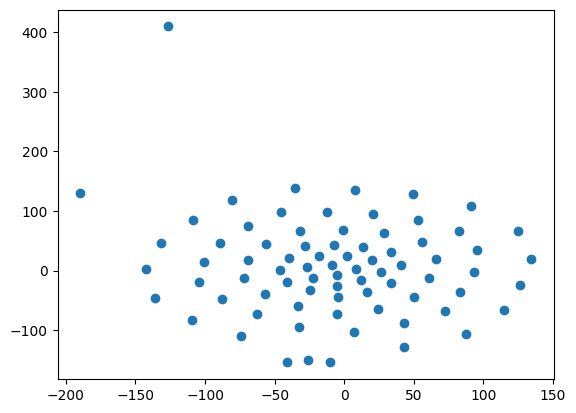

In [2]:
import clip
import torch
from PIL import Image
import torch
import numpy as np
from kmeans_pytorch import kmeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

descriptors = ["fat", "thin", "big", "skinny", "lean", "short", "pear-shaped", "tall",
               "slim", "curvy", "muscular", "chubby", "petite", "athletic", "slender", 
               "feminine", "masculine", "short", "giant"]
encoded_labels = [clip.tokenize(label) for label in descriptors]
labels = torch.stack(encoded_labels).to(device)
labels = labels.permute(1, 2, 0)[0]


x_embedded = TSNE(n_components=2, perplexity=7).fit_transform(labels.cpu().numpy())

# plot the embedded TSNE space with words in the plot
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])

In [5]:
import json
import torch

with open("/home/nadav2/dev/data/CLIP2Shape/images/flame_expressions_new/0_labels.json", "r") as f:
    data = json.load(f)

torch.tensor([d[0][0] for d in data.values()])

tensor([18.4531, 21.4375, 19.6250, 21.0000])

In [1]:
from pathlib import Path

In [3]:
files_generator = sorted(list(Path("/home/nadav2/dev/data/CLIP2Shape/images/flame_expression_py3d").rglob("*.png")), key=lambda x: int(x.stem.split("_")[0]))


In [9]:
files_generator.index(Path("/home/nadav2/dev/data/CLIP2Shape/images/flame_expression_py3d/1991.png"))

1494

In [40]:
# cluster the embeddings of CLIP labels with k-means
import clip
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
descriptors = ["fat", "thin", "skinny", "lean", "short", "pear-shaped", "tall"]
with torch.no_grad():
    labels = model.encode_text(clip.tokenize(descriptors).to(device))

In [41]:
from kmeans_pytorch import kmeans
kmeans = kmeans(X=labels, num_clusters=2, distance='cosine', device=device)

running k-means on cuda..


[running kmeans]: 2it [00:00, 697.60it/s, center_shift=0.000000, iteration=2, tol=0.000100]


/home/nadav2/anaconda3/envs/trueself_clone/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nadav2/anaconda3/envs/trueself_clone/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


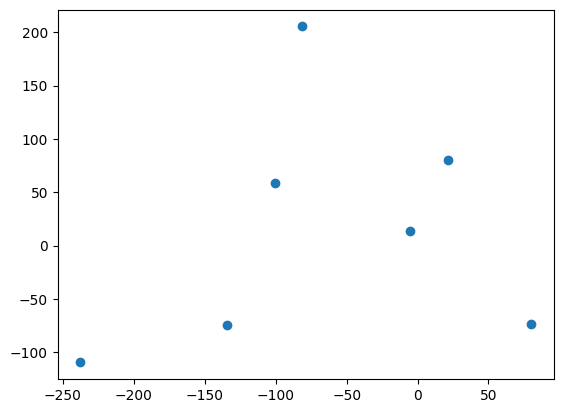

In [42]:
# plot the embedded TSNE space with words in the plot
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

x_embedded = TSNE(n_components=2, perplexity=2).fit_transform(labels.cpu().numpy())

# plot the embedded TSNE space with words in the plot
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])


In [3]:
from pathlib import Path
i = 0
for side_file in Path("/home/nadav2/dev/data/CLIP2Shape/images/flame_shape_py3d_angles").rglob("*side.png"):
    if not Path(side_file.as_posix().replace("side", "front")).exists():
        side_file.unlink()

In [8]:
import cv2
import numpy as np
from pathlib import Path

video_type = 'fat'
video_path = f"/home/nadav2/dev/data/CLIP2Shape/outs/vids/optimization/{video_type}.mp4"

cap = cv2.VideoCapture(video_path)
frame_counters = 0

while cap.isOpened():

    ret, frame = cap.read()
    if not ret:
        break
    if frame_counters % 100 == 0:
        cv2.imwrite(f"/home/nadav2/dev/data/CLIP2Shape/outs/vids/optimization/{video_type}/{frame_counters}.png", frame)
    frame_counters += 1

imgs_dir = Path(f"/home/nadav2/dev/data/CLIP2Shape/outs/vids/optimization/{video_type}")
imgs = sorted(list(imgs_dir.rglob("*.png")), key=lambda x: int(x.stem))
images = [cv2.imread(img.as_posix()) for img in imgs]
images = [cv2.resize(img, (256, 256)) for img in images]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]
images = np.concatenate(images, axis=1)
cv2.imwrite(f"/home/nadav2/dev/data/CLIP2Shape/outs/vids/optimization/{video_type}/{video_type}.png", images)

True

In [4]:
images_paths=["/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/smplx/neutral.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/smplx/fat.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/smplx/long_legs.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/smplx/narrow_waist.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/smplx/muscular.png"]

import cv2
import numpy as np
labels = ["neutral", "fat", "long legs", "narrow waist", "muscular"]
coordinates = [105, 120, 95, 85, 95]
images = [cv2.imread(img_path) for img_path in images_paths]
images = [cv2.resize(img, (256, 256)) for img in images]

for i, img in enumerate(images):
    cv2.putText(img, f'"{labels[i]}"', (coordinates[i], 248), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

images = np.concatenate(images, axis=1)
cv2.imwrite(f"/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/smplx/summary.png", images)

True

In [102]:
images_paths=["/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_expression/neutral.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_expression/open_mouth.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_expression/smile.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_expression/raise_eyebrows.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_expression/angry.png"]

import cv2
import numpy as np
labels = ["neutral", "open mouth", "smile", "raise eyebrows", "angry"]
coordinates = [95, 75, 98, 65, 100]
images = [cv2.imread(img_path) for img_path in images_paths]
images = [cv2.resize(img, (256, 256)) for img in images]

for i, img in enumerate(images):
    # add white space at the bottom
    img = cv2.copyMakeBorder(img, 0, 20, 0, 0, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    cv2.putText(img, f'"{labels[i]}"', (coordinates[i], 258), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
    images[i] = img

images = np.concatenate(images, axis=1)


cv2.imwrite(f"/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_expression/flame_expression_summary.png", images)

True

In [118]:
images_paths=["/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_shape/neutral.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_shape/fat.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_shape/long_neck.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_shape/big_forhead.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_shape/ears_sticking_out.png"]

import cv2
import numpy as np
labels = ["neutral", "fat", "long neck", "big forehead", "ears sticking out"]
coordinates = [95, 100, 95, 65, 60]
images = [cv2.imread(img_path) for img_path in images_paths]

for i, img in enumerate(images):
    # add white space at the bottom
    # coords = (0, 20) if i in [0, 2] else (40, 0)
    # coords = coords if i != 4 else (0, 40)
    img = cv2.copyMakeBorder(img,  20, 0, 0, 0, cv2.BORDER_CONSTANT, value=(255, 255, 255))

    images[i] = img

images = [cv2.resize(img, (256, 256)) for img in images]
# for i, img in enumerate(images):
#     cv2.putText(img, f'"{labels[i]}"', (coordinates[i], 250), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
images = np.concatenate(images, axis=1)
# images = cv2.copyMakeBorder(images, 0, 20, 0, 0, cv2.BORDER_CONSTANT, value=(255, 255, 255))



cv2.imwrite(f"/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_shape/summary.png", images)

True

In [119]:
import cv2
img = cv2.imread("/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_shape/summary.png")
img = cv2.copyMakeBorder(img, 0, 10, 0, 0, cv2.BORDER_CONSTANT, value=(255, 255, 255))
cv2.imwrite("/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_shape/summary.png", img)

True

In [120]:
labels = ["neutral", "fat", "long neck", "big forehead", "ears sticking out"]
coords = [97, 365, 595, 840, 1075]
img = cv2.imread("/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_shape/summary.png")
for label, coord in zip(labels, coords):
    cv2.putText(img, f'"{label}"', (coord, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
cv2.imwrite("/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/flame_shape/summary_new.png", img)

True

In [112]:
images_paths=["/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/smal/neutral.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/smal/cow.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/smal/lion.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/smal/donkey.png",
              "/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/smal/hippo.png"]

import cv2
import numpy as np
labels = ["neutral", "cow", "lion", "donkey", "hippo"]
coordinates = [125, 120, 145, 115, 140]
images = [cv2.imread(img_path) for img_path in images_paths]
images = [cv2.resize(img, (256, 256)) for img in images]

for i, img in enumerate(images):
    # add white space at the bottom
    img = cv2.copyMakeBorder(img, 0, 0, 0, 50, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    cv2.putText(img, f'"{labels[i]}"', (coordinates[i], 220), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
    images[i] = img

images = np.concatenate(images, axis=1)


cv2.imwrite(f"/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/smal/summary.png", images)

True

In [3]:
import cv2

img = cv2.imread("/home/nadav2/dev/data/CLIP2Shape/outs/vids/optimization/smile/smile.png")
img = img[20:, :, :]
cv2.imwrite("/home/nadav2/dev/data/CLIP2Shape/outs/vids/optimization/smile/smile_test.png", img)

True

In [16]:
import numpy as np
iters = [0, 100, 200, 300, 400]
coords = [220, 200, 200, 200, 200]
imgs = []
# read the images and write the iteration number on them top center
for idx, iter in enumerate(iters):
    img = cv2.imread(f"/home/nadav2/dev/data/CLIP2Shape/outs/vids/optimization/smile/{iter}.png")
    cv2.putText(img, f'iter {iter}', (coords[idx], 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    imgs.append(img)

# concatenate the images
imgs = np.concatenate(imgs, axis=1)
# white background

cv2.imwrite(f"/home/nadav2/dev/data/CLIP2Shape/outs/vids/optimization/smile/smile_test.png", imgs)
    

True

In [17]:
img = cv2.imread("/home/nadav2/dev/data/CLIP2Shape/outs/vids/optimization/smile/smile_test.png")

In [18]:
import numpy as np

# all values above 240 are set to 255
img[:, :][img > 240] = 255

# write the image
cv2.imwrite(f"/home/nadav2/dev/data/CLIP2Shape/outs/vids/optimization/smile/smile_test.png", img)

True

In [3]:
import pickle
file_path = "/home/nadav2/Downloads/ModelAgencyData/final_identities.pkl"
with open(file_path, "rb") as f:
    identities = pickle.load(f)

identities

{'neighbors': {('cocaine_models', 'Marta'): [],
  ('cocaine_models', 'Juliane'): [],
  ('cocaine_models', 'Milva'): [('the-models', 'id4072-milva')],
  ('cocaine_models', 'Anyon'): [],
  ('cocaine_models', 'Anni'): [],
  ('cocaine_models', 'Anja'): [],
  ('cocaine_models', 'Sylwia'): [],
  ('cocaine_models', 'Klara'): [],
  ('cocaine_models', 'Yala'): [],
  ('cocaine_models', 'Linn'): [],
  ('cocaine_models', 'Amie'): [],
  ('cocaine_models', 'Mila'): [],
  ('cocaine_models', 'Nora'): [],
  ('cocaine_models', 'Diana'): [],
  ('cocaine_models', 'Yulianna'): [],
  ('cocaine_models', 'Beata'): [],
  ('cocaine_models', 'Magda'): [],
  ('cocaine_models', 'Sophie S.'): [],
  ('cocaine_models', 'Anastasiya'): [],
  ('cocaine_models', 'Sabina'): [],
  ('cocaine_models', 'Paulina N.'): [],
  ('cocaine_models', 'Magdalena'): [],
  ('cocaine_models', 'Anne'): [],
  ('cocaine_models', 'Korlan'): [],
  ('cocaine_models', 'Ina'): [],
  ('cocaine_models', 'Ella'): [],
  ('cocaine_models', 'Zoe'): [],

In [117]:
import cv2
from pathlib import Path

imgs_dir = Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/summaries")

# concatenate all images in the directory

imgs = []
for img_path in imgs_dir.glob("*.png"):
    img = cv2.imread(str(img_path))
    imgs.append(img)

# resize all images to the same size
imgs = [cv2.resize(img, (1200, 256)) for img in imgs]
imgs = np.concatenate(imgs, axis=0)
cv2.imwrite(f"/home/nadav2/dev/data/CLIP2Shape/outs/images_from_demo/summaries/summary.png", imgs)



True

In [19]:
from torchvision.datasets import CelebA

celeba = CelebA(root="/home/nadav2/dev/data/celeba", download=True)

RuntimeError: The daily quota of the file img_align_celeba.zip is exceeded and it can't be downloaded. This is a limitation of Google Drive and can only be overcome by trying again later.

In [17]:
import cv2
import numpy as np
from pathlib import Path


imgs_dir = Path("/home/nadav2/dev/data/CLIP2Shape/images/supplementary_material/smplx_fat")
# create collage of these 7 images, 3 rows, 3 columns, 2 empty spaces
imgs = []
images_paths = sorted(list(imgs_dir.rglob("*.png")), key=lambda x: int(x.stem))
for img_path in images_paths:

    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (512, 512))
    imgs.append(img)
imgs = np.array(imgs)
# add empty spaces
imgs = np.concatenate([imgs, np.ones((2, 512, 512, 3)) * 255], axis=0).reshape(3, 3, 512, 512, 3)
final_image = []
for row in imgs:
    final_image.append(np.concatenate(row, axis=1))
final_image = np.concatenate(final_image, axis=0)
cv2.imwrite(f"/home/nadav2/dev/data/CLIP2Shape/images/supplementary_material/smplx_fat/summary.png", final_image)


True

In [2]:
from pathlib import Path

working_dir = Path("/home/nadav2/dev/data/CLIP2Shape/images/temp")
img_name = 1462
for file in working_dir.rglob("*.png"):
    labels_json_file = Path(file.as_posix().replace(".png", "_labels.json"))
    json_file = Path(file.as_posix().replace(".png", ".json"))
    file.rename(file.parent / f"{img_name}.png")
    json_file.rename(json_file.parent / f"{img_name}.json")
    labels_json_file.rename(labels_json_file.parent / f"{img_name}_labels.json")
    img_name += 1


In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

working_dir = Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/smplx_shape/shapy_cherry_pick/shapy_results")
raw_images_dir = working_dir / "raw_images"
shapy_predictions_dir = working_dir / "shapy_predictions"
our_predictions_dir = working_dir / "new_pose"
final_dir = working_dir / "final_new"

for raw_image_path in raw_images_dir.iterdir():
    raw_image = cv2.imread(str(raw_image_path))
    shapy_prediction = cv2.imread(str(shapy_predictions_dir / raw_image_path.name))
    our_prediction = cv2.imread(str(our_predictions_dir / raw_image_path.name))
    # set the sizes of the images to be the same as the raw image
    # shapy_prediction = cv2.resize(shapy_prediction, (raw_image.shape[1], raw_image.shape[0]))
    # our_prediction = cv2.resize(our_prediction, (raw_image.shape[1], raw_image.shape[0]))
    
    # concatenate the images
    final_image = np.concatenate([raw_image, shapy_prediction, our_prediction], axis=1)
    cv2.imwrite(str(final_dir / raw_image_path.name), final_image)


In [15]:
cv2.imread("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/smplx_shape/shapy/shapy_results/prediction/0.jpg").shape

(450, 300, 3)

In [25]:
sorted([file.name for file in Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/smplx_shape/shapy_dataset/our_predictions").rglob("*.png")])

['beach_handball_vid_001_clip_000_person_001_frame_000007_female.png',
 'beach_handball_vid_001_clip_000_person_001_frame_000009_female.png',
 'beach_handball_vid_001_clip_000_person_001_frame_000026_female.png',
 'beach_handball_vid_001_clip_000_person_001_frame_000047_female.png',
 'beach_handball_vid_001_clip_000_person_001_frame_000055_female.png',
 'beach_handball_vid_002_clip_001_person_002_frame_000026_female.png',
 'beach_handball_vid_002_clip_001_person_002_frame_000035_female.png',
 'beach_handball_vid_002_clip_001_person_002_frame_000052_female.png',
 'beach_handball_vid_002_clip_002_person_002_frame_000004_female.png',
 'beach_handball_vid_002_clip_002_person_002_frame_000007_female.png',
 'beach_handball_vid_002_clip_002_person_002_frame_000012_female.png',
 'beach_handball_vid_002_clip_002_person_002_frame_000020_female.png',
 'beach_handball_vid_002_clip_002_person_002_frame_000034_female.png',
 'beach_handball_vid_002_clip_002_person_002_frame_000055_female.png',
 'beac

In [29]:
import torch
import numpy as np 
from pathlib import Path

shape_predictions = torch.from_numpy(np.load("/home/nadav2/dev/repos/shapy/datasets/ssp_3d/labels/shapes.npy"))
data = sorted([file.name for file in Path("/home/nadav2/dev/repos/shapy/datasets/ssp_3d/images").rglob("*.png")])
 

(torch.Size([311, 10]), 311)

In [31]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path


raw_images_dir = Path("/home/nadav2/dev/repos/shapy/datasets/ssp_3d/images")
shapy_predictions_dir = Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/smplx_shape/shapy_dataset/shapy_predictions")
our_predictions_dir = Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/smplx_shape/shapy_dataset/our_predictions")
comparisons_dir = Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/smplx_shape/shapy_dataset/comparison")

for image in raw_images_dir.rglob("*.png"):
    shapy_prediction_img = cv2.imread(str(shapy_predictions_dir / image.name))
    our_prediction_img = cv2.imread(str(our_predictions_dir / image.name))
    raw_image = cv2.imread(str(image))
    # set all the images to be the same size
    shapy_prediction_img = cv2.resize(shapy_prediction_img, (raw_image.shape[1], raw_image.shape[0]))
    our_prediction_img = cv2.resize(our_prediction_img, (raw_image.shape[1], raw_image.shape[0]))
    # write on the images the image name
    cv2.putText(raw_image, "orig", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(shapy_prediction_img, "shapy", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(our_prediction_img, "ours", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    # concatenate the images
    final_image = np.concatenate([raw_image, shapy_prediction_img, our_prediction_img], axis=1)

    cv2.imwrite(str(comparisons_dir / image.name), final_image)

In [ ]:
import torch
import requests
from PIL import Image
from diffusers import StableDiffusionDepth2ImgPipeline

pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(
   "stabilityai/stable-diffusion-2-depth",
   torch_dtype=torch.float16,
).to("cuda")

In [1]:
import torch
midas = torch.load("/home/nadav2/Downloads/dpt_beit_large_512.pt")

In [18]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x7f36d85997f0>)

In [19]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /home/nadav2/.cache/torch/hub/intel-isl_MiDaS_master


FileNotFoundError: [Errno 2] No such file or directory: './externals/Next_ViT/classification/nextvit.py'

In [4]:
import pandas as pd

df = pd.read_csv("/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/heatmap.csv")

In [16]:
import timm
timm.list_models()[150:]

['hardcorenas_c',
 'hardcorenas_d',
 'hardcorenas_e',
 'hardcorenas_f',
 'hrnet_w18',
 'hrnet_w18_small',
 'hrnet_w18_small_v2',
 'hrnet_w30',
 'hrnet_w32',
 'hrnet_w40',
 'hrnet_w44',
 'hrnet_w48',
 'hrnet_w64',
 'ig_resnext101_32x8d',
 'ig_resnext101_32x16d',
 'ig_resnext101_32x32d',
 'ig_resnext101_32x48d',
 'inception_resnet_v2',
 'inception_v3',
 'inception_v4',
 'lambda_resnet26t',
 'lambda_resnet50t',
 'legacy_senet154',
 'legacy_seresnet18',
 'legacy_seresnet34',
 'legacy_seresnet50',
 'legacy_seresnet101',
 'legacy_seresnet152',
 'legacy_seresnext26_32x4d',
 'legacy_seresnext50_32x4d',
 'legacy_seresnext101_32x4d',
 'mixer_b16_224',
 'mixer_b16_224_in21k',
 'mixer_b32_224',
 'mixer_l16_224',
 'mixer_l16_224_in21k',
 'mixer_l32_224',
 'mixer_s16_224',
 'mixer_s16_glu_224',
 'mixer_s32_224',
 'mixnet_l',
 'mixnet_m',
 'mixnet_s',
 'mixnet_xl',
 'mixnet_xxl',
 'mnasnet_050',
 'mnasnet_075',
 'mnasnet_100',
 'mnasnet_140',
 'mnasnet_a1',
 'mnasnet_b1',
 'mnasnet_small',
 'mobilene

In [14]:
import numpy as np
file = "/home/nadav2/Downloads/00000.npy"
tex_map = np.load(file, allow_pickle=True)


In [17]:
tex_map.shape

(256, 256)

In [22]:
import cv2
from pathlib import Path
from clip2mesh.utils import Utils

utils = Utils()
images = [cv2.imread(file.as_posix()) for file in Path("/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/flame_shape").rglob("*.png")]
num_rows, num_cols = utils.get_plot_shape(len(images))[0]

horizontal_images = []
for i in range(num_rows):
    horizontal_images.append(np.concatenate(images[i*num_cols:(i+1)*num_cols], axis=1))

final_image = np.concatenate(horizontal_images, axis=0)

cv2.imwrite("/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/flame_shape/summary.png", final_image)


True

In [32]:
import torch
import numpy as np
from scipy.spatial.transform import Rotation as R

pose = [0.0, 0.0, 0.0, -0.47309866547584534, 0.0017460905946791172, 0.009093362838029861, -0.3611382842063904, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7272552251815796, 0.0, 0.0, 0.5413447618484497, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17929764091968536, -0.33138298988342285, -0.692484438419342, 0.02501579187810421, 0.36109107732772827, 0.768018364906311, 0.9082790017127991, -1.5054086446762085, 0.3057611584663391, -0.14498627185821533, 1.043287754058838, 0.7634777426719666, -1.181429386138916, 0.05783149600028992, -0.05619499087333679, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

pose = np.array(pose).reshape(-1, 3)
body_pose = pose.reshape(-1, 3)[1:22]
left_hand_pose = pose.reshape(-1,3)[25:40]
right_hand_pose = pose.reshape(-1,3)[40:55]
body_pose = torch.FloatTensor([R.from_rotvec(r).as_matrix() for r in body_pose]).unsqueeze(0)

In [34]:
np.save("/home/nadav2/dev/repos/Thesis/SMPLX/test.npy", body_pose)

In [4]:
import h5py

f = h5py.File("/home/nadav2/dev/data/CLIP2Shape/GT_data/people_snapshot_public/female-1-casual/reconstructed_poses.hdf5", "r")
np.array(f["betas"]).shape, print(f.keys())

<KeysViewHDF5 ['betas', 'pose', 'trans']>


((10,), None)

In [6]:
import pickle
import numpy as np
f = np.load("/home/nadav2/dev/data/CLIP2Shape/GT_data/people_snapshot_public/female-1-casual/consensus.pkl", allow_pickle=True)
f

UnpicklingError: Failed to interpret file '/home/nadav2/dev/data/CLIP2Shape/GT_data/people_snapshot_public/female-1-casual/consensus.pkl' as a pickle

In [9]:
import numpy as np
np.load("/home/nadav2/dev/data/CLIP2Shape/GT_data/people_snapshot_public/female-1-casual/consensus.pkl", allow_pickle=True)

UnpicklingError: Failed to interpret file '/home/nadav2/dev/data/CLIP2Shape/GT_data/people_snapshot_public/female-1-casual/consensus.pkl' as a pickle

In [16]:
512 * 512 * 3

786432

In [17]:
import cv2

vid = cv2.VideoCapture("/home/nadav2/dev/data/CLIP2Shape/GT_data/people_snapshot_public/female-1-casual/female-1-casual.mp4")

# split video into frames
success, image = vid.read()
count = 0
while success:

    success, image = vid.read()

    cv2.imwrite(f"/home/nadav2/dev/data/CLIP2Shape/GT_data/people_snapshot_public/female-1-casual/imgs/{count}.png", image)

    count += 1

vid.release()



KeyboardInterrupt: 

In [1]:
from pathlib import Path

for img in Path("/home/nadav2/dev/data/CLIP2Shape/GT_data/people_snapshot_public/female-1-casual/imgs").rglob("*.png"):
    img.rename(img.as_posix().replace("._female.png", "_female.png"))

In [2]:
import numpy as np

test = np.load("/home/nadav2/dev/repos/shapy/samples/shapy_fit/img_20.npz", allow_pickle=True)

In [45]:
np.array(test)

array(['fname', 'joints', 'vertices', 'v_shaped', 'faces', 'global_rot',
       'raw_global_rot', 'body_pose', 'raw_body_pose', 'betas', 'camera',
       'measurements', 'proj_joints', 'shift_x', 'shift_y', 'transl',
       'focal_length_in_mm', 'focal_length_in_px', 'center',
       'sensor_width'], dtype='<U18')

In [52]:
np.array(test["camera"])

array([ 0.6248215 , -0.08887385,  0.27209795], dtype=float32)

In [56]:
import shutil
from pathlib import Path
dest_dir = Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/smplx_shape/shapy_cherry_pick/out_vids")
for img in Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/smplx_shape/shapy_cherry_pick/comparison").rglob("out_vid.mp4"):
    shutil.copy(img, dest_dir / (img.parent.name + ".mp4"))

In [60]:
import cv2
import h5py
from tqdm import tqdm
from pathlib import Path
files_generator = list(Path("/home/nadav2/dev/data/CLIP2Shape/GT_data/people_snapshot_public").iterdir())
for sample in tqdm(files_generator, total=len(files_generator)):

    video_path = sample / (sample.name + ".mp4")
    features_path = sample / "reconstructed_poses.hdf5"
    featres_data = h5py.File(features_path, "r")
    betas = np.array(featres_data["betas"])
    pose = np.array(featres_data["pose"])
    frames_dir = sample / "frames"
    frames_dir.mkdir(exist_ok=True)
    vid = cv2.VideoCapture(video_path.as_posix())
    frames_count = 0
    while True:
        success, image = vid.read()
        if not success:
            break
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.imwrite((frames_dir / f"{frames_count}.png").as_posix(), image)
        frames_count += 1
    vid.release()

    np.save(sample / "betas.npy", betas)
    np.save(sample / "pose.npy", pose)

100%|██████████| 24/24 [11:02<00:00, 27.59s/it]


In [62]:
files_generator = Path("/home/nadav2/dev/repos/shapy/samples/frames").rglob("*.jpg")
for img in files_generator:
    # change suffix to jpg
    img.rename(img.with_suffix(".png"))

In [76]:
import json
import numpy as np

with open("/home/nadav2/dev/repos/shapy/samples/openpose/img_21.json") as f:
    data = json.load(f)

np.array(data["people"][0]["pose_keypoints_2d"]).reshape(-1, 3).shape

(25, 3)

In [72]:
21 * 3

63

In [78]:
from pathlib import Path
import shutil
dest_dir = Path("/home/nadav2/dev/data/CLIP2Shape/GT_data/out_vids")
for file in Path("/home/nadav2/dev/data/CLIP2Shape/GT_data/our_predictions").rglob("out_vid.mp4"):
    shutil.copy(file, dest_dir / (file.parent.name + ".mp4"))

In [95]:
dest_dir = Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/NeuralBody_DATA/raw_images_dataset")
for folder in Path("/home/nadav2/dev/data/CLIP2Shape/GT_data/people_snapshot_public").iterdir():
    frames_dir = folder / "frames"
    first_100 = sorted(list(frames_dir.iterdir()), key=lambda x: int(x.stem))[:50:2]
    for img in first_100:
        shutil.copy(img, dest_dir / f"{frames_dir.parent.name}_{img.name}")

In [93]:
import numpy as np

np.load("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/NeuralBody_DATA/pixie_predictions/female-1-casual_0/female-1-casual_0_param.pkl", allow_pickle=True)["shape"]

array([-2.14859918e-01, -4.98302013e-01,  4.00962569e-02,  3.18466544e-01,
       -3.32907438e-01, -1.04075164e-01, -1.79700866e-01,  6.17277361e-02,
        5.39849281e-01,  3.78921255e-03,  5.31005338e-02, -4.20844406e-02,
       -7.46472627e-02, -5.39007902e-01,  4.18320507e-01,  1.60469934e-01,
       -2.48776034e-01,  1.33585989e-01,  3.30857933e-04,  2.77695775e-01,
       -3.48951072e-01,  4.12444770e-01,  2.55586445e-01,  2.56679580e-03,
       -2.09142044e-02,  1.23951510e-01,  7.42454410e-01,  1.18437782e-02,
        1.28834531e-01, -7.24854618e-02, -3.06253970e-01,  5.35795242e-02,
       -3.07580769e-01,  2.95302749e-01, -3.85076612e-01,  1.05795175e-01,
       -1.96339563e-01, -1.01171508e-01,  3.53654176e-01, -7.83612654e-02,
        3.26493800e-01,  6.36405170e-01, -3.08113366e-01, -1.83648616e-03,
        2.02873588e-01,  5.39906248e-02,  1.12119824e-01,  4.39804107e-01,
        4.58876044e-01, -1.02705605e-01,  9.61101279e-02,  2.05466703e-01,
        1.93617791e-01, -

In [8]:
import shutil
from pathlib import Path

jsons_dir = Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/NeuralBody_DATA/data/keypoints_jsons_males")
imgs_dir = Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/NeuralBody_DATA/data/raw_images_dataset")
dest_dir = Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/NeuralBody_DATA/data/sampled_images_males")

for json_file in jsons_dir.iterdir():
    img_name = json_file.stem.replace("_keypoints", "") + ".png"
    shutil.copy(imgs_dir / img_name, dest_dir / img_name)

In [14]:
import numpy as np

pixie_shape = np.load("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/NeuralBody_DATA/predicitons/pixie_predictions/female-1-casual_0/female-1-casual_0_param.pkl", allow_pickle=True)

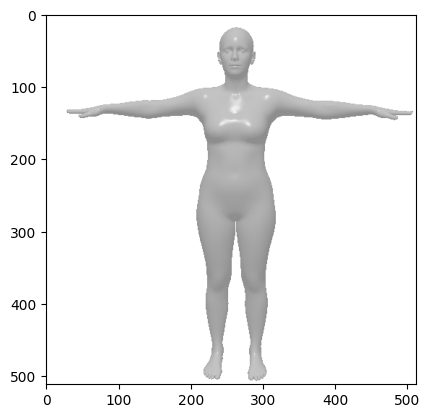

In [28]:
import torch
import matplotlib.pyplot as plt
from clip2mesh.utils import Utils, Pytorch3dRenderer

renderer = Pytorch3dRenderer(
    img_size=(512, 512),
    dist=2.2,
    elev=11.0,
    azim=4.0
)
utils = Utils()

test_shape = torch.tensor(pixie_shape)[None]
verts, faces, vt, ft = utils.get_smplx_model(betas=test_shape, gender="female")

img = renderer.render_mesh(verts, faces, vt, ft)
img = np.clip(img.cpu().numpy()[0, ..., :3] * 255, 0, 255).astype(np.uint8)
plt.imshow(img)

In [55]:
import h5py
import torch

with h5py.File("/home/nadav2/dev/data/CLIP2Shape/GT_data/people_snapshot_public/male-1-casual/reconstructed_poses.hdf5", "r") as f:
    print(torch.tensor(f["betas"]).shape)

torch.Size([10])


In [45]:
import numpy as np

np.load("/home/nadav2/dev/data/CLIP2Shape/GT_data/people_snapshot_public/male-1-casual/pose.npy")[0].reshape(-1, 3, 3)

array([[[ 3.6531191e+00, -6.5609789e-03, -1.5198787e-01],
        [-4.9781062e-02,  8.4277578e-02,  2.7643848e-02],
        [-3.5978884e-02, -6.8269111e-02, -2.6928356e-03]],

       [[ 1.5473260e-02,  2.7757734e-02, -7.4690278e-03],
        [-3.8537074e-02, -2.7150851e-02,  2.2131668e-03],
        [-2.0049160e-02, -2.2906102e-02, -1.1486768e-02]],

       [[ 9.6407436e-02, -2.0405214e-02,  5.5653084e-02],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[-5.1409043e-03,  2.0428097e-03, -1.4919983e-02],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[-1.1702933e-01, -2.5791442e-02,  8.8349031e-03],
        [-2.4849461e-02,  1.3397677e-01, -1.8011114e-01],
        [-6.3667640e-02, -3.7407286e-02,  1.8484095e-01]],

       [[-9.7647823e-02,  2.3383411e-02,  4.6133045e-02],
        [ 2.1639460e-01, -8.4835589e-02, -7.3412913e-01],
    

In [59]:
from clip2mesh.utils import Utils

test = 5
suggested_video_struct, num_imgs = Utils().get_plot_shape(test)
if num_imgs < test:
    suggested_video_struct = list(suggested_video_struct)
while num_imgs < test:
    suggested_video_struct[1] += 1
    num_imgs += 1
suggested_video_struct = tuple(suggested_video_struct)
print(suggested_video_struct)
print(num_imgs)

(2, 3)
5


In [60]:
(2, 3) * (2, 3)

TypeError: can't multiply sequence by non-int of type 'tuple'

In [61]:
len({"x": 1, "y": 2})

2

In [5]:
from pathlib import Path

for file in Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/NeuralBody_DATA/data/sampled_images").iterdir():
    file.rename(file.parent / (file.stem.split("_")[0] + ".png"))

In [1]:
import json

with open("/home/nadav2/dev/data/CLIP2Shape/Human3DScan/train/s03/smplx/001.json", "r") as f:
    data = json.load(f)
data.keys()

dict_keys(['transl', 'global_orient', 'body_pose', 'betas', 'left_hand_pose', 'right_hand_pose', 'jaw_pose', 'leye_pose', 'reye_pose', 'expression'])

In [8]:
data["body_pose"].__len__()

454

In [10]:
import cv2
import numpy as np

cv2.minAreaRect(np.array([[0, 0], [0, 1], [1, 1], [1, 0]]))

((0.5, 0.5), (1.0, 1.0), 90.0)

In [30]:
cv2.minAreaRect(np.array([[0, 0], [0, 1], [1, 1], [1, 0]]))

((0.5, 0.5), (1.0, 1.0), 90.0)

In [25]:
box

array([[0, 0],
       [0, 1],
       [1, 1],
       [1, 0]])

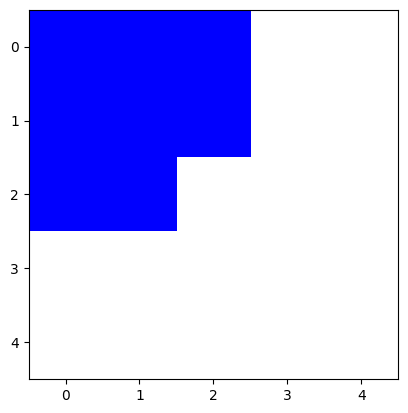

In [24]:
# draw the bounding box of the rotated text
box = (np.array([[0, 0], [0, 1], [1, 1], [1, 0]]))
box = np.int0(box)
# cv2.drawContours(image, [box], 0, (0, 0, 255), 2)

import matplotlib.pyplot as plt
import numpy as np

img = np.ones((5, 5, 3), dtype=np.uint8) * 255
img = cv2.drawContours(img, [box], 0, (0, 0, 255), 2)
plt.imshow(img)


In [3]:
import shutil
from pathlib import Path
dest = Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/smplx_shape/shapy_cherry_pick/out_vids")
for file in Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/smplx_shape/shapy_cherry_pick/comparison").rglob("out_vid.mp4"):
    shutil.copy(file, dest / (file.parent.name + ".mp4"))

In [12]:
import numpy as np
import matplotlib.pyplot as plt
sorted_indices = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
cmap = plt.get_cmap("YlOrRd")
colors = cmap(np.linspace(0, 1, len(np.argsort(sorted_indices))))[:, :3]

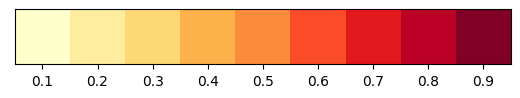

In [17]:
# display the colors according to their index
plt.imshow(np.array([colors[np.argsort(sorted_indices)]]))
# set the xticks to be the sorted indices
plt.xticks(np.argsort(sorted_indices), sorted_indices)
plt.yticks([])
plt.show()

In [21]:
import pandas as pd

df = pd.read_csv("/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/optimizations/smplx_multiview/vertex_heatmaps/vertex_heatmaps.csv")

# sort effect by value
df = df.sort_values(by="effect", ascending=False)
df

,descriptor,effect,sorted_indices
11,pear shaped,394.639000,[4420 5720 3550 ... 7345 7609 7484]
2,narrow waist,393.114040,[3294 4114 3293 ... 7641 7643 7626]
13,long legs,380.646800,[3294 3295 4114 ... 632 709 631]
9,proportioned,361.977420,[3294 3978 3293 ... 9337 9340 9341]
14,curvy,348.405640,[3294 3293 3978 ... 7609 7345 7484]
16,rectangular,318.237030,[3294 3978 3293 ... 9340 632 9341]
17,round apple,278.480400,[3978 3294 3293 ... 6824 8357 8399]
7,muscular,189.105830,[3221 3223 3297 ... 3843 6598 5604]
18,sturdy,171.644230,[8267 6153 6157 ... 8965 8992 9005]
19,small,158.157790,[3217 3218 3221 ... 3843 6598 5604]


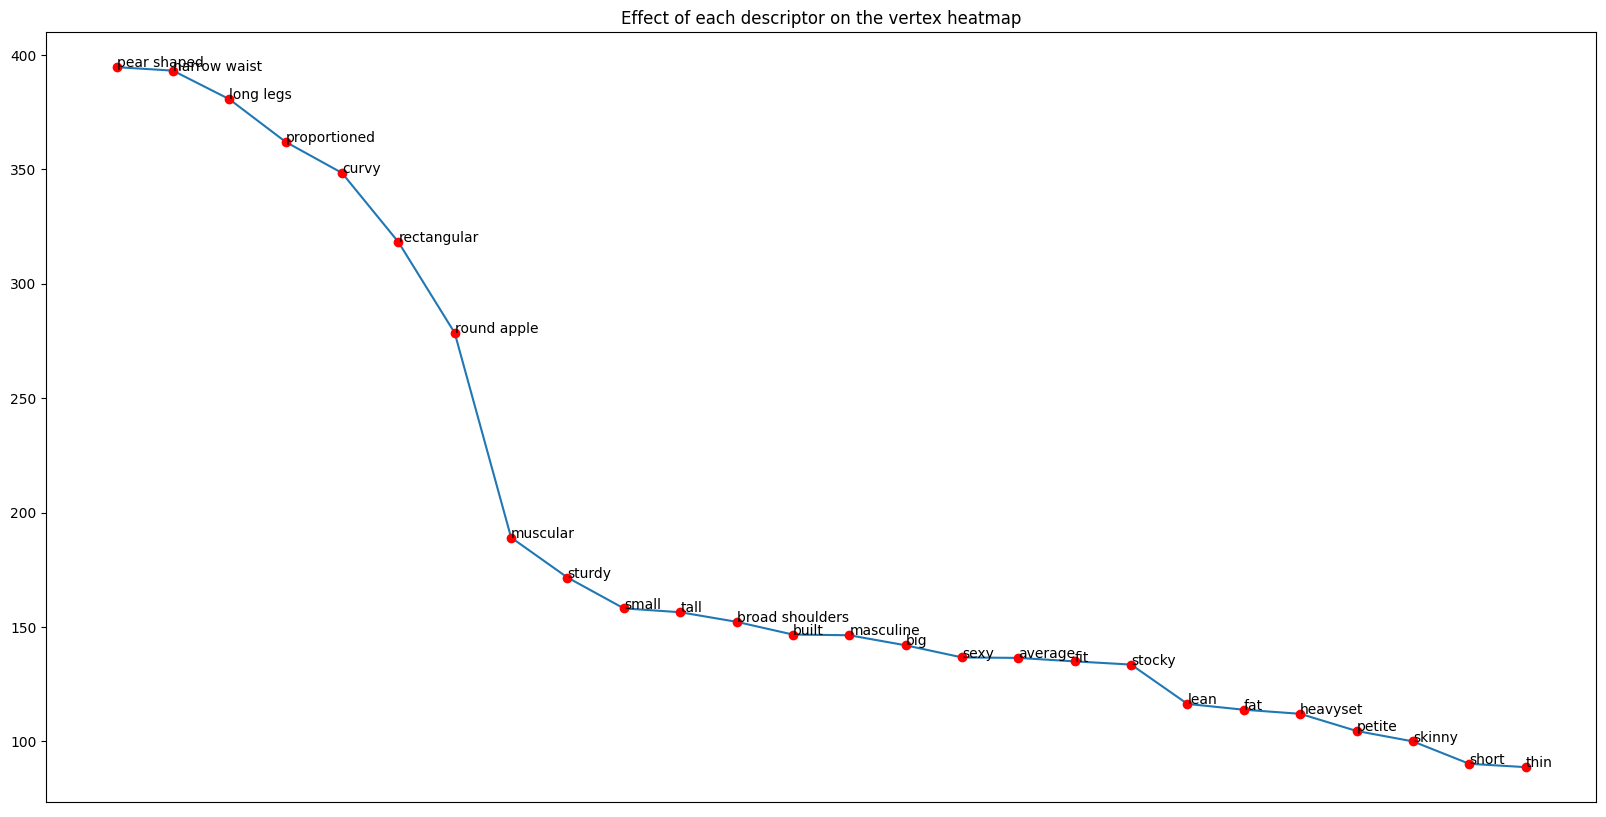

In [32]:
# plot the effect values sorted by effect value and add the name of the descriptor
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
plt.plot(df["effect"].values)

# add text to the plot with the name of the descriptor abd a dot at the effect value
for i, (effect, name) in enumerate(zip(df["effect"].values, df["descriptor"].values)):
    plt.text(i, effect, name, fontsize=10)
    plt.plot(i, effect, "o", color="red")
plt.xticks([])
plt.title("Effect of each descriptor on the vertex heatmap")


plt.show()
fig.tight_layout()
# save the plot
fig.savefig("/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/outs/plots/vertex_heatmap_effect.png")

In [35]:
# search for overlapping indices between the descriptors

# get the indices of the descriptors
df["sorted_indices"]

11    [4420 5720 3550 ... 7345 7609 7484]
2     [3294 4114 3293 ... 7641 7643 7626]
13    [3294 3295 4114 ...  632  709  631]
9     [3294 3978 3293 ... 9337 9340 9341]
14    [3294 3293 3978 ... 7609 7345 7484]
16    [3294 3978 3293 ... 9340  632 9341]
17    [3978 3294 3293 ... 6824 8357 8399]
7     [3221 3223 3297 ... 3843 6598 5604]
18    [8267 6153 6157 ... 8965 8992 9005]
19    [3217 3218 3221 ... 3843 6598 5604]
6     [3217 3218 3221 ... 3843 6598 5604]
20    [3217 3218 3220 ... 5940 5943 6714]
1     [3221 3223 3328 ... 3843 6598 5604]
22    [3331 3945 3944 ... 3966 5943 6714]
21    [6626 7175 6629 ... 6598 5604 3734]
8     [3936 3331 3332 ... 6715 6714 5943]
0     [3944 3331 3332 ... 3843 6598 5604]
24    [3217 3936 3218 ... 3966 5943 6714]
3     [3936 3331 3945 ... 5948 6714 5943]
15    [3217 3944 3214 ... 6713 5943 6714]
25    [3956 3944 3919 ... 3843 6598 5604]
5     [6821 6883 6822 ... 3843 3734 5604]
4     [3956 3945 3957 ... 6598 5604 5603]
23    [3205 3204 3956 ... 6714 594

In [2]:
import numpy as np

np.load("/home/nadav2/dev/repos/EasyMocap/data/smplx/J_regressor_body25.npy").shape

(25, 6890)

In [6]:
import json

with open("/home/nadav2/dev/data/CLIP2Shape/Human3DScan/train/s01/smplx/001.json", "r") as f:
    data = json.load(f)
data["betas"].__len__()

354

In [15]:
from pathlib import Path

Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/Human3DScan_DATA/data/female_2/004/stats.json").parts[-3:-1]

('female_2', '004')

In [2]:
from clip2mesh.utils import Utils

utils = Utils()

In [21]:
utils.video_to_frames("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/Human3DScan_DATA/raw_videos/male_1/170/2.mp4")

In [8]:
from pathlib import Path


for folder in Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/Human3DScan_DATA/raw_videos/female_2").iterdir():
    for subfolder in folder.iterdir():
        if "keypoints" in subfolder.name:
            counter = 0
            for file in sorted(list(subfolder.iterdir()), key=lambda x: int(x.stem.split("_")[1])):
                print(file.as_posix().replace(file.stem, f"{counter:05d}_keypoints"))
                file.rename(file.as_posix().replace(file.stem, f"{counter:05d}_keypoints"))
                counter += 1

/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/Human3DScan_DATA/raw_videos/female_2/048/1_keypoints/00000_keypoints.json
/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/Human3DScan_DATA/raw_videos/female_2/048/1_keypoints/00001_keypoints.json
/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/Human3DScan_DATA/raw_videos/female_2/048/1_keypoints/00002_keypoints.json
/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/Human3DScan_DATA/raw_videos/female_2/048/1_keypoints/00003_keypoints.json
/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/Human3DScan_DATA/raw_videos/female_2/048/1_keypoints/00004_keypoints.json
/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/Human3DScan_DATA/raw_videos/female_2/048/1_keypoints/00005_keypoints.json
/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/Human3DScan_DATA/raw_videos/female_2/048/1_keypoints/00006_keypoints.json
/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/Human3DScan_DATA/raw_videos/female_2/048/1_keypoin

In [4]:
import numpy as np 


np.load("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/Human3DScan_DATA/predictions/pixie_predictions/male_1/113/1/00000/00000_prediction.pkl", allow_pickle=True)["smplx_kpt"]

array([[-0.02811828, -0.10850713],
       [ 0.05959707, -0.13357764],
       [-0.1171381 , -0.09720652],
       [-0.05694991, -0.2313017 ],
       [ 0.04359626,  0.34286162],
       [-0.10880412,  0.37969735],
       [-0.04932954, -0.3776557 ],
       [-0.06383793,  0.80047905],
       [-0.21629198,  0.8620549 ],
       [-0.0329622 , -0.4315806 ],
       [ 0.05991426,  0.85428387],
       [-0.12258739,  0.9221277 ],
       [-0.0515148 , -0.64075154],
       [-0.00544657, -0.5281481 ],
       [-0.06775551, -0.5171755 ],
       [-0.05520862, -0.87556386],
       [ 0.03174049, -0.58085597],
       [-0.15114763, -0.5423585 ],
       [ 0.07727002, -0.2774667 ],
       [-0.16887213, -0.21775591],
       [ 0.18987288, -0.01310705],
       [-0.06178035,  0.05998002],
       [-0.04240381, -0.77834666],
       [ 0.04632524, -0.82523394],
       [ 0.0202549 , -0.8094376 ],
       [ 0.24191663,  0.06864701],
       [ 0.2498321 ,  0.10243671],
       [ 0.24094614,  0.12462328],
       [ 0.23977329,

In [1]:
import numpy as np
np.load("/home/nadav2/dev/data/CLIP2Shape/Zju_Mocap_Dataset/CoreView_313/params/2.npy", allow_pickle=True).tolist()["shapes"]

array([[ 0.20782161, -1.55503249,  1.31726336,  2.07879066, -0.22140498,
         0.48044801, -0.22032435, -0.16634706,  0.31423905, -0.20944613]])

In [48]:
np.load("/home/nadav2/dev/data/CLIP2Shape/Zju_Mocap_Dataset/CoreView_313/new_params/346.npy", allow_pickle=True).tolist()["shapes"] == np.load("/home/nadav2/dev/data/CLIP2Shape/Zju_Mocap_Dataset/CoreView_313/lbs/smpl_params.npy", allow_pickle=True).tolist()["shapes"][1459]


array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

In [4]:
import numpy as np
np.load("/home/nadav2/dev/data/CLIP2Shape/Zju_Mocap_Dataset/CoreView_313/lbs/smpl_params.npy", allow_pickle=True).tolist()["shapes"].__len__(
)

1469

In [40]:
from pathlib import Path
for folder in Path("/home/nadav2/dev/data/CLIP2Shape/Zju_Mocap_Dataset/CoreView_313/keypoints2d").iterdir():
    if "Camera" in folder.name:
        folder.rename(folder.as_posix().replace(" (", "_").replace(")", ""))

In [46]:
from pathlib import Path

for i in range(1, 5):
    Path(f"/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/ZjuMocap_DATA/shapy_predictions/313/Camera_B{i}").mkdir()

In [24]:
import smplx
import numpy as np
import torch
smplx_path = "/home/nadav2/dev/repos/Thesis/SMPL/SMPL_NEUTRAL.pkl"
smplx_layer = smplx.build_layer(model_path=smplx_path, num_expression_coeffs=10, model_type="smpl")
verts = (smplx_layer(betas=torch.zeros(1, 10)).vertices).cuda()

In [16]:
import torch
smpl_faces = np.load("/home/nadav2/dev/repos/Thesis/SMPL/SMPL_NEUTRAL.npz", allow_pickle=True)
smpl_faces = torch.tensor(np.array(smpl_faces["f"]).astype(np.int32))[None].cuda()

In [23]:
verts.shape

torch.Size([1, 6890, 3])

In [10]:
from pytorch3d.structures import Meshes

mesh = Meshes(verts=verts, faces=smpl_faces)

In [11]:
from pytorch3d.io import save_obj
save_obj("/home/nadav2/dev/repos/Thesis/SMPL/test.obj", verts=verts[0], faces=smpl_faces[0])

/home/nadav2/anaconda3/envs/clip2mesh/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:810: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [10]:
smpl_faces.shape

torch.Size([20908, 3])

In [19]:
from clip2mesh.utils import Pytorch3dRenderer

renderer = Pytorch3dRenderer()
# renderer.render_mesh(verts=verts, faces=smpl_faces)
renderer.render_mesh(mesh=mesh)

/opt/conda/conda-bld/pytorch_1631630839582/work/aten/src/ATen/native/cuda/IndexKernel.cu:97: operator(): block: [15,0,0], thread: [9,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1631630839582/work/aten/src/ATen/native/cuda/IndexKernel.cu:97: operator(): block: [15,0,0], thread: [10,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1631630839582/work/aten/src/ATen/native/cuda/IndexKernel.cu:97: operator(): block: [15,0,0], thread: [11,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1631630839582/work/aten/src/ATen/native/cuda/IndexKernel.cu:97: operator(): block: [15,0,0], thread: [12,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1631630839582/work/aten/src/ATen/native/cuda/IndexKernel.cu:97: operator(): bloc

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [14]:
import pickle

with open("/home/nadav2/dev/repos/SPIN/data/smpl/smpl/models/basicmodel_f_lbs_10_207_0_v1.1.0.pkl", "rb") as f:
    data = pickle.load(f)
data

/tmp/ipykernel_24603/2139525443.py:4: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  data = pickle.load(f)


UnicodeDecodeError: 'ascii' codec can't decode byte 0x81 in position 1224: ordinal not in range(128)

In [2]:
import torch
import numpy as np
import smplx
from smplx import SMPL as _SMPL
from smplx.body_models import ModelOutput
from smplx.lbs import vertices2joints

import config
import constants

class SMPL(_SMPL):
    """ Extension of the official SMPL implementation to support more joints """

    def __init__(self, *args, **kwargs):
        super(SMPL, self).__init__(*args, **kwargs)
        joints = [constants.JOINT_MAP[i] for i in constants.JOINT_NAMES]
        J_regressor_extra = np.load(config.JOINT_REGRESSOR_TRAIN_EXTRA)
        self.register_buffer('J_regressor_extra', torch.tensor(J_regressor_extra, dtype=torch.float32))
        self.joint_map = torch.tensor(joints, dtype=torch.long)

    def forward(self, *args, **kwargs):
        kwargs['get_skin'] = True
        smpl_output = super(SMPL, self).forward(*args, **kwargs)
        extra_joints = vertices2joints(self.J_regressor_extra, smpl_output.vertices)
        joints = torch.cat([smpl_output.joints, extra_joints], dim=1)
        joints = joints[:, self.joint_map, :]
        output = ModelOutput(vertices=smpl_output.vertices,
                             global_orient=smpl_output.global_orient,
                             body_pose=smpl_output.body_pose,
                             joints=joints,
                             betas=smpl_output.betas,
                             full_pose=smpl_output.full_pose)
        return output

ImportError: cannot import name 'ModelOutput' from 'smplx.body_models' (/home/nadav2/anaconda3/envs/clip2mesh/lib/python3.8/site-packages/smplx/body_models.py)

In [98]:
import smplx
smpl_model_path = "/home/nadav2/dev/repos/Thesis/SMPL/SMPL_NEUTRAL.pkl"
smpl_layer = smplx.build_layer(model_path=smpl_model_path, num_expression_coeffs=10, model_type="smpl", num_betas=100, gender="female")
smpl_faces = smpl_layer.faces_tensor

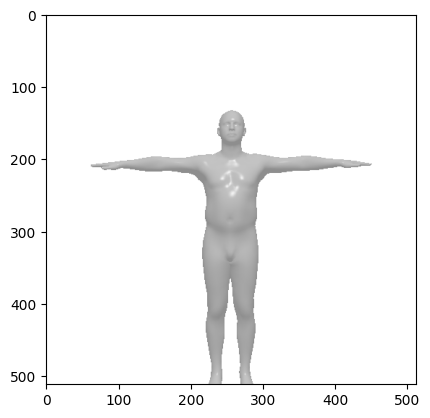

In [99]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from clip2mesh.utils import Pytorch3dRenderer

def adjust_rendered_img(img: torch.Tensor) -> np.ndarray:
    img = np.clip(img.cpu().numpy()[0, ..., :3] * 255, 0, 255).astype(np.uint8)
    return img

renderer = Pytorch3dRenderer(img_size=(512, 512), dist=4.4, elev=0.0, azim=0.0)
rend_img = renderer.render_mesh(verts=smpl_layer(betas=torch.randn(1, 100)).vertices, faces=smpl_faces)
plt.imshow(adjust_rendered_img(rend_img))


In [18]:
from pathlib import Path

working_dir = Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/NeuralBody_DATA/data/videos")
video_name = "male-5-outdoor"
videos_dir = working_dir / f"{video_name}_keypoints"

# replace female-3-sport_keypoints with '' in all files, and convert the format from 8d to 5d

for file in videos_dir.iterdir():
    file.rename(file.parent / file.name.replace(f"{video_name}_", ""))

for file in sorted(videos_dir.iterdir(), key=lambda x: int(x.stem.split('_')[0])):
    new_format = f"{int(file.stem.split('_')[0]):05d}_keypoints.json"
    file.rename(file.parent / new_format)

In [26]:
import cv2
from tqdm import tqdm
from pathlib import Path

video_name = "female-3-sport"
video_file = working_dir / f"{video_name}.mp4"
frames_dir = working_dir / f"{video_name}_frames"
frames_dir.mkdir(exist_ok=True)

cap = cv2.VideoCapture(str(video_file))
num_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_idx = 0
progress_bar = tqdm(total=num_of_frames)
while cap.isOpened():

    ret, frame = cap.read()
    if not ret:
        break

    cv2.imwrite(str(frames_dir / f"{frame_idx:05d}.png"), frame)
    frame_idx += 1
    progress_bar.update(1)

cap.release()
progress_bar.close()

100%|██████████| 511/511 [00:23<00:00, 22.06it/s]


In [29]:
from pathlib import Path

working_dir = Path("/home/nadav2/dev/data/CLIP2Shape/outs/images_to_shape/ZjuMocap_DATA/predictions/shapy_predictions/313")
for folder in working_dir.iterdir():
    if folder.is_file():
        continue
    for file in sorted(folder.iterdir(), key=lambda x: int(x.stem.split('_')[4])):
        new_format = f"{int(file.stem.split('_')[4]):05d}.npz"
        file.rename(file.parent / new_format)


In [6]:
ffteen = np.array([0.005281091667711735, 0.004479144234210253, 0.012689181603491306, 0.005299370735883713, 0.004434141330420971, 0.008425695821642876, 0.031823039054870605, 0.019443029537796974, 0.0095183365046978, 0.01128937304019928])
ten = np.array([0.004699202254414558, 0.004438586533069611, 0.013817823491990566, 0.004389668814837933, 0.0020837080664932728, 0.0044293999671936035, 0.027379235252738, 0.011440766975283623, 0.006380270700901747, 0.006842339877039194])
five = np.array([0.0043882932513952255, 0.004747152328491211, 0.014209059998393059, 0.010269657708704472, 0.011830929666757584, 0.007106058765202761, 0.03452065587043762, 0.01442804653197527, 0.010444246232509613, 0.009885560721158981])

import matplotlib.pyplot as plt
import numpy as np

print("15:", np.sum(ffteen))
print("10:", np.sum(ten))
print("5:", np.sum(five))


15: 0.11268240353092551
10: 0.0859010019339621
5: 0.1218296610750258


In [9]:
ten.shape

(10,)

In [54]:
import pandas as pd
import numpy as np
import json

and_term_path = "/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/optimizations/test_arik_algorithm/smplx_male/chosen_descriptors_and_term.json"
or_term_path = "/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/optimizations/test_arik_algorithm/smplx_male/chosen_descriptors_or_term.json"

with open(and_term_path, "r") as f:
    and_term = json.load(f)

and_df = pd.DataFrame(columns=["cluster_id", "descriptor", "iou", "vertex_coverage"])
for cluster_id, cluster in and_term.items():
    for descriptor, data in cluster.items():
        and_df = pd.concat([and_df, pd.DataFrame({"cluster_id": [cluster_id], "descriptor": [descriptor], "iou": [data["iou"]], "vertex_coverage": [data["vertex_coverage"]]}, columns=["cluster_id", "descriptor", "iou", "vertex_coverage"])])

and_df.sort_values(by=["cluster_id", "vertex_coverage"], ascending=False, inplace=True)
and_df.to_csv("/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/optimizations/test_arik_algorithm/smplx_male/chosen_descriptors_and_term.csv", index=False)
and_df

,cluster_id,descriptor,iou,vertex_coverage
0,2,rectangular,0.115619,372
0,2,pear shaped,0.131134,250
0,1,broad shoulders,0.473804,123
0,1,narrow waist,0.144994,79
0,1,tall,0.440582,73
0,1,fat,0.343964,46
0,0,curvy,0.136591,258
0,0,short,0.415300,127
0,0,long legs,0.146455,103
0,0,muscular,0.422063,64


In [53]:
with open(or_term_path, "r") as f:
    or_term = json.load(f)

or_df = pd.DataFrame(columns=["cluster_id", "descriptor", "iou", "vertex_coverage"])

for cluster_id, cluster in or_term.items():
    for descriptor, data in cluster.items():
        or_df = pd.concat([or_df, pd.DataFrame({"cluster_id": [cluster_id], "descriptor": [descriptor], "iou": [data["iou"]], "vertex_coverage": [data["vertex_coverage"]]}, columns=["cluster_id", "descriptor", "iou", "vertex_coverage"])])

or_df.sort_values(by=["cluster_id", "vertex_coverage"], ascending=False, inplace=True)
or_df.to_csv("/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/optimizations/test_arik_algorithm/smplx_male/chosen_descriptors_or_term.csv", index=False)
or_df

,cluster_id,descriptor,iou,vertex_coverage
0,2,pear shaped,0.131134,250
0,2,small,0.434548,68
0,2,stocky,0.260947,67
0,2,heavyset,0.325956,43
0,1,broad shoulders,0.473804,123
0,1,thin,0.391858,105
0,1,average,0.473099,102
0,1,narrow waist,0.144994,79
0,1,fat,0.343964,46
0,1,big,0.315101,41


In [61]:
sorted(("3488 3490 3491 3492 3493 3494 3495 3503 3505 3506 3507 3508 3509 3510\
 3511 3539 3542 3543 3544 3545 3734 3735 3736 3792 3793 3794 3795 3796\
 3797 3798 3799 3804 3839 3840 3841 3842 3843 3858 3860 3861 3863 3864\
 3879 3914 3915 3916 3917 3971 3972 3986 3995 3996 4084 4085 4086 4110\
 4111 4112 4113 4130 4131 4132 4133 4134 4144 4146 4148 4291 4320 4321\
 4420 4422 4423 4424 4425 5510 5511 5513 5600 5601 5603 5604 5615 5706\
 5707 5709 5710 5716 5717 5718 5719 5721 5722 5723 5725 5942 5946 5949\
 6251 6252 6253 6254 6255 6256 6267 6269 6270 6271 6272 6300 6303 6304\
 6305 6306 6550 6551 6552 6553 6554 6555 6556 6557 6595 6596 6597 6598\
 6609 6611 6612 6614 6615 6662 6663 6664 6665 6719 6720 6734 6744 6828\
 6829 6830 6856 6857 6874 6875 6876 6877 6892 7158 7159 7160 7161 8232\
 8233 8400 8401 8403 8404 8410 8411 8412 8413 8416 8417 9021 9025").split(" "))


['3488',
 '3490',
 '3491',
 '3492',
 '3493',
 '3494',
 '3495',
 '3503',
 '3505',
 '3506',
 '3507',
 '3508',
 '3509',
 '3510',
 '3511',
 '3539',
 '3542',
 '3543',
 '3544',
 '3545',
 '3734',
 '3735',
 '3736',
 '3792',
 '3793',
 '3794',
 '3795',
 '3796',
 '3797',
 '3798',
 '3799',
 '3804',
 '3839',
 '3840',
 '3841',
 '3842',
 '3843',
 '3858',
 '3860',
 '3861',
 '3863',
 '3864',
 '3879',
 '3914',
 '3915',
 '3916',
 '3917',
 '3971',
 '3972',
 '3986',
 '3995',
 '3996',
 '4084',
 '4085',
 '4086',
 '4110',
 '4111',
 '4112',
 '4113',
 '4130',
 '4131',
 '4132',
 '4133',
 '4134',
 '4144',
 '4146',
 '4148',
 '4291',
 '4320',
 '4321',
 '4420',
 '4422',
 '4423',
 '4424',
 '4425',
 '5510',
 '5511',
 '5513',
 '5600',
 '5601',
 '5603',
 '5604',
 '5615',
 '5706',
 '5707',
 '5709',
 '5710',
 '5716',
 '5717',
 '5718',
 '5719',
 '5721',
 '5722',
 '5723',
 '5725',
 '5942',
 '5946',
 '5949',
 '6251',
 '6252',
 '6253',
 '6254',
 '6255',
 '6256',
 '6267',
 '6269',
 '6270',
 '6271',
 '6272',
 '6300',
 '6303',
 

In [63]:
sorted(("3431 3440 3441 3462 3463 3464 3465 3466 3467 3468 3469 3470 3471 3472\
 3473 3477 3478 3479 3480 3481 3482 3483 3484 3500 3501 3502 3512 3513\
 3514 3515 3517 3527 3528 3529 3530 3531 3532 3533 3534 3535 3563 3565\
 3566 3574 3588 3591 3592 3595 3596 3597 3598 3599 3600 3601 3602 3603\
 3604 3605 3606 3607 3608 3609 3610 3611 3612 3613 3614 3615 3616 3617\
 3618 3619 3620 3622 3623 3624 3631 3633 3634 3638 3640 3651 3652 3653\
 3654 3656 3663 3664 3665 3666 3667 3668 3773 3801 3802 3803 3865 3866\
 3867 3884 3885 3890 3902 3903 3958 3959 3993 3994 4002 4065 4066 4080\
 4081 4088 4091 4092 4093 4094 4095 4096 4297 4298 4401 4403 4404 4405\
 4408 4409 5412 5490 5491 5492 5493 5497 5517 5520 5557 5574 5575 5613\
 5614 5658 5659 5660 5661 5662 5663 5664 5665 5666 5667 5668 5669 5670\
 5671 5672 5673 5674 5675 5676 5677 5678 5680 5681 5682 5683 5684 5685\
 5686 5687 5688 5689 5690 5691 5692 5693 5694 5695 5696 5697 5698 5700\
 5704 5705 5711 5712 5713 5714 5934 6023 6024 6025 6026 6050 6069 6070\
 6113 6114 6189 6190 6191 6192 6193 6194 6195 6209 6221 6222 6227 6228\
 6229 6230 6231 6232 6233 6234 6235 6236 6261 6262 6277 6278 6279 6280\
 6281 6289 6314 6579 6580 6618 6634 6635 6708 6709 6726 6741 6868 6869\
 7137 7138 7139 7140 7141 7142 7143 7144 7145 7146 7147 7148 8135 8145\
 8146 8219 8220 8221 8222 8223 8225 8227 8228 8238 8239 8240 8358 8362\
 8363 8369 8370 8371 8372 8373 8377 8378 8379 8380 8381 8382 8383 8384\
 8385 8386 8389 8390 8391 8392 8393 8406 8722 8724").split(" "))


['3431',
 '3440',
 '3441',
 '3462',
 '3463',
 '3464',
 '3465',
 '3466',
 '3467',
 '3468',
 '3469',
 '3470',
 '3471',
 '3472',
 '3473',
 '3477',
 '3478',
 '3479',
 '3480',
 '3481',
 '3482',
 '3483',
 '3484',
 '3500',
 '3501',
 '3502',
 '3512',
 '3513',
 '3514',
 '3515',
 '3517',
 '3527',
 '3528',
 '3529',
 '3530',
 '3531',
 '3532',
 '3533',
 '3534',
 '3535',
 '3563',
 '3565',
 '3566',
 '3574',
 '3588',
 '3591',
 '3592',
 '3595',
 '3596',
 '3597',
 '3598',
 '3599',
 '3600',
 '3601',
 '3602',
 '3603',
 '3604',
 '3605',
 '3606',
 '3607',
 '3608',
 '3609',
 '3610',
 '3611',
 '3612',
 '3613',
 '3614',
 '3615',
 '3616',
 '3617',
 '3618',
 '3619',
 '3620',
 '3622',
 '3623',
 '3624',
 '3631',
 '3633',
 '3634',
 '3638',
 '3640',
 '3651',
 '3652',
 '3653',
 '3654',
 '3656',
 '3663',
 '3664',
 '3665',
 '3666',
 '3667',
 '3668',
 '3773',
 '3801',
 '3802',
 '3803',
 '3865',
 '3866',
 '3867',
 '3884',
 '3885',
 '3890',
 '3902',
 '3903',
 '3958',
 '3959',
 '3993',
 '3994',
 '4002',
 '4065',
 '4066',
 

WARNING - 2023-01-18 19:05:40,336 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


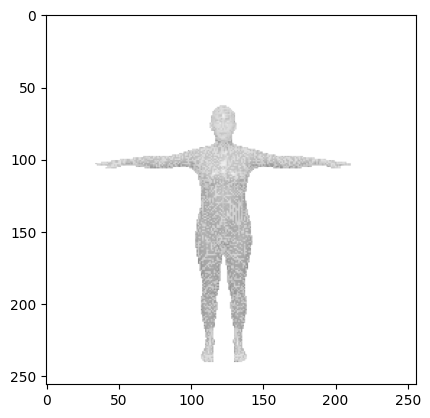

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from clip2mesh.utils import Pytorch3dRenderer, Utils

utils = Utils()

renderer = Pytorch3dRenderer(azim=0, elev=10, dist=4.6, img_size=(256, 256), device="cuda:0")
verts, faces, vt, ft = utils.get_smplx_model()
verts += np.array([0.5, 0.5, 0.0])
plt.imshow(renderer.render_mesh(verts, faces, vt, ft).detach().cpu().numpy().squeeze())

In [1]:
from tqdm import tqdm
from pathlib import Path
import shutil

dest_path = Path("/home/nadav2/dev/data/CLIP2Shape/images/smplx_male_multiview_3k")
generator = sorted(list(Path("/home/nadav2/dev/data/CLIP2Shape/images/smplx_male_multiview").rglob("*.json")), key=lambda x: int(x.stem))

counter = 0
for file in tqdm(generator, total=len(generator), desc="Copying files"):
    json_file = file
    front_img = file.parent / f"{file.stem}_front.png"
    side_img = file.parent / f"{file.stem}_side.png"
    shutil.copy(json_file, dest_path / json_file.name)
    shutil.copy(front_img, dest_path / front_img.name)
    shutil.copy(side_img, dest_path / side_img.name)
    counter += 1
    if counter == 3000:
        break

Copying files:  30%|██▉       | 2999/10000 [00:12<00:29, 234.97it/s]


In [2]:
import clip

clip_model, preprocess = clip.load("ViT-B/32", device="cuda:0")



AttributeError: module 'clip' has no attribute 'encode_text'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


WARNING - 2023-01-19 20:20:53,940 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1024, 1024, 4])


(<matplotlib.image.AxesImage at 0x7f048d918550>, None)

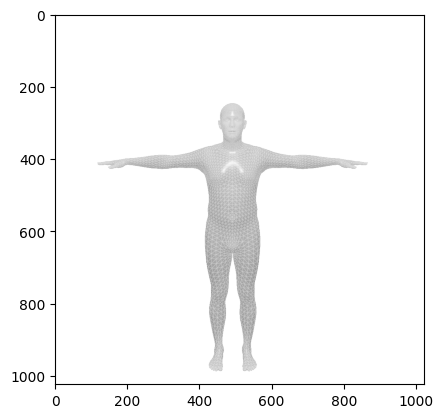

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from clip2mesh.utils import Pytorch3dRenderer, Utils

utils = Utils()


plt.imshow(rend_img.detach().cpu().numpy().squeeze()), print(rend_img.shape)

In [1]:
import clip
import torch
import numpy as np
from torchvision.transforms import Resize

resizer = Resize((224, 224))

from clip2mesh.utils import Pytorch3dRenderer, Utils
utils = Utils()
model, preprocess = clip.load("ViT-B/32")
renderer = Pytorch3dRenderer(azim=0, elev=10, dist=4.6, img_size=(896, 896), device="cuda:0")
verts, faces, vt, ft = utils.get_smplx_model(gender="male")
verts += np.array([0.5, 0.5, 0.0])
rend_img = renderer.render_mesh(verts, faces, vt, ft)

with torch.no_grad():
    image_features = model.encode_image(resizer(rend_img[..., :3].permute(0, 3, 1, 2))).float()
    text_features = model.encode_text(clip.tokenize(["a man"]).to("cuda")).float()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from pathlib import Path
import shutil
counter = 3000
working_dir = Path("/home/nadav2/dev/data/CLIP2Shape/images")
orig_dir = working_dir / "tall_data"
dest_dir = working_dir / "smplx_male_multiview_3k"

for front_file in orig_dir.rglob("*_front.png"):
    side_file = Path(front_file.as_posix().replace("_front", "_side"))
    bs_file = front_file.parent / f"{front_file.stem.split('_')[0]}.json"
    shutil.copy(front_file, dest_dir / f"{counter}_front.png")
    shutil.copy(side_file, dest_dir / f"{counter}_side.png")
    shutil.copy(bs_file, dest_dir / f"{counter}.json")
    counter += 1
    